In [44]:
# necessray imports
import random 
import numpy as np 
import pandas as pd
from pprint import pprint
from pathlib import Path
import glob
import os

import tensorflow as tf 
from keras import backend as K
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, BatchNormalization, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import KFold



## gukven ob das oder nicht das
# Seed value for reproducability according to https://stackoverflow.com/questions/32419510/how-to-get-reproducible-results-in-keras

seed_value=3
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.compat.v1.set_random_seed(seed_value)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)



## FUNCTIONS 

# load the data of all subjects which are saved in a csv file as time series 
# convert the data into a numpy array and reshape them to sequences of 30 minutes with 2 parameters 
# being glucose and heart rate 

def load_data(path):
    csv_files = glob.glob(path + "/*.csv")

    # create list of the csv files from the folder in which each subject has its own file
    df_list = (pd.read_csv(file) for file in csv_files)

    # Concatenate all DataFrames with corresponding glucose and heart-rate values in teh right order
    df  = pd.concat(df_list, ignore_index=True)
    df['HR'] = df['HR'].astype(float)
    df['Glucose'] = df['Glucose'].astype(float)
    df['HR2'] = df['HR2'].astype(float)
    df['Glucose2'] = df['Glucose2'].astype(float)
    df['HR3'] = df['HR3'].astype(float)
    df['Glucose3'] = df['Glucose3'].astype(float)
    df['HR4'] = df['HR4'].astype(float)
    df['Glucose4'] = df['Glucose4'].astype(float)
    df['HR5'] = df['HR5'].astype(float)
    df['Glucose5'] = df['Glucose5'].astype(float)
    df['HR6'] = df['HR6'].astype(float)
    df['Glucose6'] = df['Glucose6'].astype(float)
    df['Class'] = df['Class'].astype(int)
    df_y = df['Class']
    df = df[['Glucose','HR', 'Glucose2','HR2', 'Glucose3','HR3', 'Glucose4','HR4', 'Glucose5', 'HR5', 'Glucose6','HR6']]

    # reshape the array so that each time sequence consists of 6 rows of one glucose and one heartrate value
    X = df.to_numpy().reshape(-1,6,2)
    y = df_y.to_numpy().reshape(-1,1)

    return X, y

# function to undersample the time series for a better balance of classes
# As input, a dictionary with wanted samples per class is given as well as the time series (X) with corresponding classes (y)
def undersampling(X,y, dict):
    # the X array needs to be resampled since the RandomUnderSampler only accepts 2D arrays
    new_X = X.reshape(-1,12)  
    undersample = RandomUnderSampler(sampling_strategy=dict, replacement=False)
    X_under, y_under = undersample.fit_resample(new_X, y)
    X_under = X_under.reshape(-1,6,2)
    y_under = y_under.reshape(-1,1)

    return X_under, y_under


# 1DCNN model qith one convolutional layer, which needs the undersampled time series (X_under) and the classes
def Model_1DCNN(X_under, classes):
    model_1dCNN = Sequential()

    # Convolutional block
    model_1dCNN.add(Conv1D(filters=126, kernel_size=3,input_shape=[X_under.shape[1], X_under.shape[2]], activation='relu'))
    model_1dCNN.add(BatchNormalization())
    model_1dCNN.add(tf.keras.layers.GlobalAveragePooling1D())

    model_1dCNN.add(Flatten())

    # Fully connected layers
    model_1dCNN.add(Dense(units=50, activation='relu'))
    model_1dCNN.add(Dropout(rate=0.3))
    model_1dCNN.add(Dense(units=25, activation='relu'))

    # Output layer with Softmax activation function
    model_1dCNN.add(Dense(units=classes, activation='softmax'))

    # Compile the Model for every iteration
    model_1dCNN.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['sparse_categorical_accuracy'])

    return model_1dCNN



# function calling the 1DCNN model with 10 fold cross validation, takes the X_train, y_train, X_test, y_test data as input
# The train data consists of all time series of one patient group and the test data of the other patient group
# then, the filename for the training and testing data is given as the models and confusion matrices are saved under the given name
# lastly a batchsize and epoch length is chosen

def start_model(X_train, y_train, X_test, y_test, train_name, test_name, batchsize=16, epoch= 500):
    # Early stopping callback is defined, which stops when the validation loss does not decrease 
    early_stopping = EarlyStopping(patience=10, monitor='val_loss', mode='min', verbose=1, restore_best_weights=True)
    # Learning rate is decreased as well if the validation loss does not decrease 
    reduceLR =ReduceLROnPlateau(monitor='val_loss', patience= 3, verbose= 1, mode='min', factor=  0.2, min_lr = 1e-6) 
    checkpoint = ModelCheckpoint('CustomModel.weights.hdf5', monitor='val_loss', verbose=1,save_best_only=True, mode= 'min') 
    callbacks= [early_stopping, checkpoint, reduceLR]

    # estimating distribution of classes to calucate weights for each class
    labels_df = pd.DataFrame(y_train, columns = ['label'])
    class_occurences = np.bincount(labels_df['label'])
    total = class_occurences.sum()
    number_classes = len(class_occurences)

    # assigning weights for classes
    weight_for_0 = (1/class_occurences[0]) * (total/number_classes)
    weight_for_1 = (1/class_occurences[1]) * (total/number_classes)
    weight_for_2 = (1/class_occurences[2]) * (total/number_classes)
    weight_for_3 = (1/class_occurences[3]) * (total/number_classes)
    weight_for_4 = (1/class_occurences[4]) * (total/number_classes)
    weight_for_5= (1/class_occurences[5]) * (total/number_classes)
    weight_for_6 = (1/class_occurences[6]) * (total/number_classes)

    class_weights = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2, 3: weight_for_3, 4: weight_for_4, 5: weight_for_5, 6: weight_for_6}

    # Decide number of K and initialize the KFold
    num_folds = 10
    kfolds = KFold(n_splits=num_folds, shuffle=True)

    # Empty lists in which the scores and variables for each fold will be stored
    accuracies_CV = []
    actual_labels_CV = []
    predicted_labels_CV = []

    # Iterate over each fold
    for train_idx, test_idx in kfolds.split(X_train):
        # Split the dataset into training and validation sets for the current fold
        X_train_fold, X_test_fold = X_train[train_idx,:], X_train[test_idx,:]
        y_train_fold, y_test_fold = y_train[train_idx], y_train[test_idx]

        # splitting training data into training and validation for monitoring hte callback conditions
        X_train_fold, X_val_fold, y_train_fold, y_val_fold = train_test_split(
        X_train_fold, y_train_fold, test_size=0.20, shuffle = True)

        # store the actual labels so that the performance can be measured as well as the loss function
        actual_labels_CV = np.append(actual_labels_CV, y_test_fold)

        # Create a new model for each fold
        model_CV = Model_1DCNN(X_train, 7)

        # Train the model on the current fold
        model_CV.fit(X_train_fold, y_train_fold,
        validation_data=(X_val_fold, y_val_fold),
        epochs=epoch,
        batch_size=batchsize,
        callbacks=callbacks,
        class_weight = class_weights,
        )
        # Evaluate the model on the test set
        y_pred = model_CV.predict(X_test_fold)
        y_pred_CV = np.argmax(y_pred, axis=1)
        accuracy_CV = accuracy_score(y_test_fold, y_pred_CV)
        accuracies_CV.append(accuracy_CV)

        # store the predicted labels for each fold to calcualte the overall metrics and visualize the confusion matrix in the end
        predicted_labels_CV = np.append(predicted_labels_CV, y_pred_CV)

    # Calculate and print mean and standard deviation of evaluation metrics
    mean_accuracy_CV = np.mean(accuracies_CV)
    std_accuracy_CV = np.std(accuracies_CV)

    # print the accuarcy and the Confusion Matrix and save the figure and model
    print(f"\nMean accuracy: {mean_accuracy_CV:.4f}, Standard deviation: {std_accuracy_CV:.4f} of trained model")
    ConfusionMatrixDisplay.from_predictions(actual_labels_CV, predicted_labels_CV, cmap=plt.cm.Blues)
    name_img_train = "Confusion_Matrices/%s.png" % (train_name)
    plt.savefig(name_img_train)
    plt.show()
    print('Report of Training:')
    print(classification_report(actual_labels_CV, predicted_labels_CV))
    name = "Models/%s.hdf5" % (train_name)
    model_CV.save(name)

    # Evaluate Model on Test Data, show the confusion matrix and save the confusion matrix
    model_CV.evaluate(X_test, y_test)
    predictions_1dCNN = model_CV.predict(X_test)
    y_pred_1dCNN = np.argmax(predictions_1dCNN, axis=1) 
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred_1dCNN, cmap=plt.cm.Blues)
    name_img_test = "Confusion_Matrices/%s.png" % (test_name)
    plt.savefig(name_img_test)
    plt.show()
    print('Report of Testing:')
    print(classification_report(y_test, y_pred_1dCNN))


# function to test the trained D1NAMO model with the explored thresholds
# this function is only called for the threshold exploration and takes as input the name of the trained D1NAMO model,
# the time series (X_under_pre) and corresponding classes (y_under_pre) of the threshold and 
# the target name for the confusion matrix which is saved
    
def Testing_from_D1NAMO(filename, X_under_pre, y_under_pre, target_name):
    reconstructed_model = tf.keras.models.load_model(filename)
    reconstructed_model.evaluate(X_under_pre, y_under_pre)
    predictions_1dCNN = reconstructed_model.predict(X_under_pre)
    y_pred_1dCNN = np.argmax(predictions_1dCNN, axis=1) 
    ConfusionMatrixDisplay.from_predictions(y_under_pre, y_pred_1dCNN, cmap=plt.cm.Blues)
    name_img_test = target_name 
    plt.savefig(name_img_test)
    plt.show()
    print('Report of Testing:')
    print(classification_report(y_under_pre, y_pred_1dCNN))

## Threshold 70

In [45]:
# define the paths and call the load data function to have a time series representation of the data
path_pre = '/Users/beyzacinar/Desktop/TSC_Hypoglycemia/Stacked_Daten/bereinigtStacked/prediab'
X_pre, y_pre = load_data(path_pre)

path_t1 = '/Users/beyzacinar/Desktop/TSC_Hypoglycemia/Stacked_Daten/bereinigtStacked/d1namo'
X_t1, y_t1 = load_data(path_t1)

Train data is BigLab and test data is D1NAMO with threshold 70
Epoch 1/500
 1/30 [>.............................] - ETA: 6s - loss: 2.4406 - sparse_categorical_accuracy: 0.0625
Epoch 1: val_loss improved from inf to 2.28319, saving model to CustomModel.weights.hdf5
30/30 [==============================] - 0s 3ms/step - loss: 1.9503 - sparse_categorical_accuracy: 0.2163 - val_loss: 2.2832 - val_sparse_categorical_accuracy: 0.2137 - lr: 0.0010
Epoch 2/500
 1/30 [>.............................] - ETA: 0s - loss: 2.0104 - sparse_categorical_accuracy: 0.1875
Epoch 2: val_loss improved from 2.28319 to 2.19707, saving model to CustomModel.weights.hdf5
30/30 [==============================] - 0s 1ms/step - loss: 1.7235 - sparse_categorical_accuracy: 0.3555 - val_loss: 2.1971 - val_sparse_categorical_accuracy: 0.1709 - lr: 0.0010
Epoch 3/500
 1/30 [>.............................] - ETA: 0s - loss: 1.6328 - sparse_categorical_accuracy: 0.2500
Epoch 3: val_loss improved from 2.19707 to 2.10278, s

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 7: val_loss improved from 1.64841 to 1.49591, saving model to CustomModel.weights.hdf5
30/30 [==============================] - 0s 1ms/step - loss: 1.3822 - sparse_categorical_accuracy: 0.4475 - val_loss: 1.4959 - val_sparse_categorical_accuracy: 0.3077 - lr: 0.0010
Epoch 8/500
 1/30 [>.............................] - ETA: 0s - loss: 1.4239 - sparse_categorical_accuracy: 0.5000
Epoch 8: val_loss improved from 1.49591 to 1.46674, saving model to CustomModel.weights.hdf5
30/30 [==============================] - 0s 1ms/step - loss: 1.3489 - sparse_categorical_accuracy: 0.4133 - val_loss: 1.4667 - val_sparse_categorical_accuracy: 0.3162 - lr: 0.0010
Epoch 9/500
 1/30 [>.............................] - ETA: 0s - loss: 1.2310 - sparse_categorical_accuracy: 0.5000
Epoch 9: val_loss improved from 1.46674 to 1.43579, saving model to CustomModel.weights.hdf5
30/30 [==============================] - 0s 1ms/step - loss: 1.3104 - sparse_categorical_accuracy: 0.4283 - val_loss: 1.4358 - val_s

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 22: val_loss improved from 1.05527 to 1.05202, saving model to CustomModel.weights.hdf5
30/30 [==============================] - 0s 1ms/step - loss: 1.2459 - sparse_categorical_accuracy: 0.4518 - val_loss: 1.0520 - val_sparse_categorical_accuracy: 0.4786 - lr: 4.0000e-05
Epoch 23/500
 1/30 [>.............................] - ETA: 0s - loss: 1.0361 - sparse_categorical_accuracy: 0.6250
Epoch 23: val_loss improved from 1.05202 to 1.04560, saving model to CustomModel.weights.hdf5
30/30 [==============================] - 0s 1ms/step - loss: 1.2456 - sparse_categorical_accuracy: 0.4946 - val_loss: 1.0456 - val_sparse_categorical_accuracy: 0.4872 - lr: 4.0000e-05
Epoch 24/500
 1/30 [>.............................] - ETA: 0s - loss: 1.1814 - sparse_categorical_accuracy: 0.6250
Epoch 24: val_loss improved from 1.04560 to 1.04139, saving model to CustomModel.weights.hdf5
30/30 [==============================] - 0s 1ms/step - loss: 1.1970 - sparse_categorical_accuracy: 0.4882 - val_loss: 1

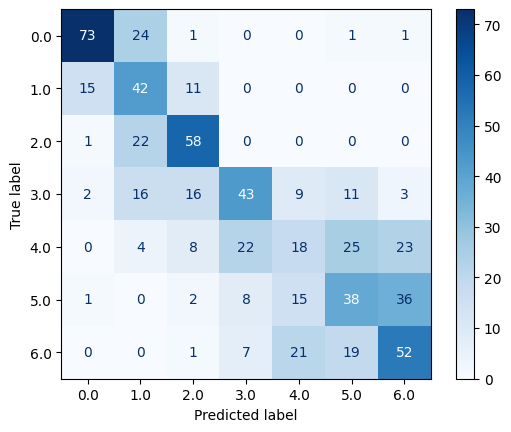

Report of Training:
              precision    recall  f1-score   support

         0.0       0.79      0.73      0.76       100
         1.0       0.39      0.62      0.48        68
         2.0       0.60      0.72      0.65        81
         3.0       0.54      0.43      0.48       100
         4.0       0.29      0.18      0.22       100
         5.0       0.40      0.38      0.39       100
         6.0       0.45      0.52      0.48       100

    accuracy                           0.50       649
   macro avg       0.49      0.51      0.49       649
weighted avg       0.50      0.50      0.49       649

20/20 [==============================] - 0s 402us/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


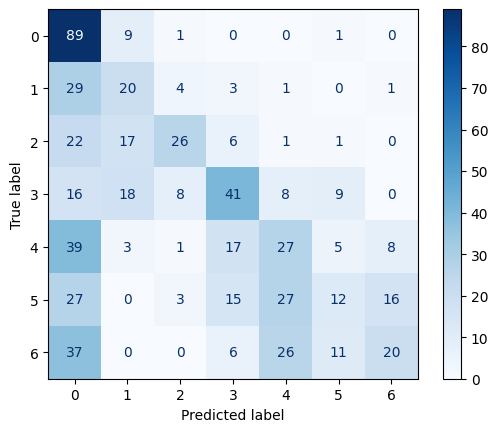

Report of Testing:
              precision    recall  f1-score   support

           0       0.34      0.89      0.50       100
           1       0.30      0.34      0.32        58
           2       0.60      0.36      0.45        73
           3       0.47      0.41      0.44       100
           4       0.30      0.27      0.28       100
           5       0.31      0.12      0.17       100
           6       0.44      0.20      0.28       100

    accuracy                           0.37       631
   macro avg       0.39      0.37      0.35       631
weighted avg       0.39      0.37      0.35       631

Train data is D1NAMO and test data is BigLab with threshold 70
Epoch 1/500
 1/29 [>.............................] - ETA: 5s - loss: 1.8891 - sparse_categorical_accuracy: 0.1250
Epoch 1: val_loss improved from inf to 2.52297, saving model to CustomModel.weights.hdf5
29/29 [==============================] - 0s 3ms/step - loss: 1.9139 - sparse_categorical_accuracy: 0.2274 - val_loss: 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 7: val_loss improved from 1.43019 to 1.33560, saving model to CustomModel.weights.hdf5
29/29 [==============================] - 0s 1ms/step - loss: 1.4203 - sparse_categorical_accuracy: 0.4238 - val_loss: 1.3356 - val_sparse_categorical_accuracy: 0.4825 - lr: 0.0010
Epoch 8/500
 1/29 [>.............................] - ETA: 0s - loss: 1.2819 - sparse_categorical_accuracy: 0.3750
Epoch 8: val_loss improved from 1.33560 to 1.28851, saving model to CustomModel.weights.hdf5
29/29 [==============================] - 0s 2ms/step - loss: 1.3783 - sparse_categorical_accuracy: 0.4260 - val_loss: 1.2885 - val_sparse_categorical_accuracy: 0.5000 - lr: 0.0010
Epoch 9/500
 1/29 [>.............................] - ETA: 0s - loss: 1.5398 - sparse_categorical_accuracy: 0.2500
Epoch 9: val_loss improved from 1.28851 to 1.26736, saving model to CustomModel.weights.hdf5
29/29 [==============================] - 0s 1ms/step - loss: 1.3783 - sparse_categorical_accuracy: 0.4481 - val_loss: 1.2674 - val_s

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 33: val_loss improved from 1.13283 to 1.13093, saving model to CustomModel.weights.hdf5
29/29 [==============================] - 0s 1ms/step - loss: 1.1951 - sparse_categorical_accuracy: 0.5286 - val_loss: 1.1309 - val_sparse_categorical_accuracy: 0.5526 - lr: 2.0000e-04
Epoch 34/500
 1/29 [>.............................] - ETA: 0s - loss: 0.9935 - sparse_categorical_accuracy: 0.5000
Epoch 34: val_loss did not improve from 1.13093
29/29 [==============================] - 0s 985us/step - loss: 1.2253 - sparse_categorical_accuracy: 0.5022 - val_loss: 1.1476 - val_sparse_categorical_accuracy: 0.5175 - lr: 2.0000e-04
Epoch 35/500
 1/29 [>.............................] - ETA: 0s - loss: 1.3403 - sparse_categorical_accuracy: 0.2500
Epoch 35: val_loss did not improve from 1.13093
29/29 [==============================] - 0s 997us/step - loss: 1.1893 - sparse_categorical_accuracy: 0.5088 - val_loss: 1.1388 - val_sparse_categorical_accuracy: 0.5526 - lr: 2.0000e-04
Epoch 36/500
 1/29 [>..

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 28: val_loss improved from 1.09518 to 1.06960, saving model to CustomModel.weights.hdf5
29/29 [==============================] - 0s 1ms/step - loss: 1.2206 - sparse_categorical_accuracy: 0.5198 - val_loss: 1.0696 - val_sparse_categorical_accuracy: 0.5439 - lr: 2.0000e-04
Epoch 29/500
 1/29 [>.............................] - ETA: 0s - loss: 1.1744 - sparse_categorical_accuracy: 0.6250
Epoch 29: val_loss improved from 1.06960 to 1.06890, saving model to CustomModel.weights.hdf5
29/29 [==============================] - 0s 1ms/step - loss: 1.2109 - sparse_categorical_accuracy: 0.5022 - val_loss: 1.0689 - val_sparse_categorical_accuracy: 0.5351 - lr: 2.0000e-04
Epoch 30/500
 1/29 [>.............................] - ETA: 0s - loss: 0.8949 - sparse_categorical_accuracy: 0.6875
Epoch 30: val_loss improved from 1.06890 to 1.06678, saving model to CustomModel.weights.hdf5
29/29 [==============================] - 0s 1ms/step - loss: 1.2480 - sparse_categorical_accuracy: 0.5198 - val_loss: 1

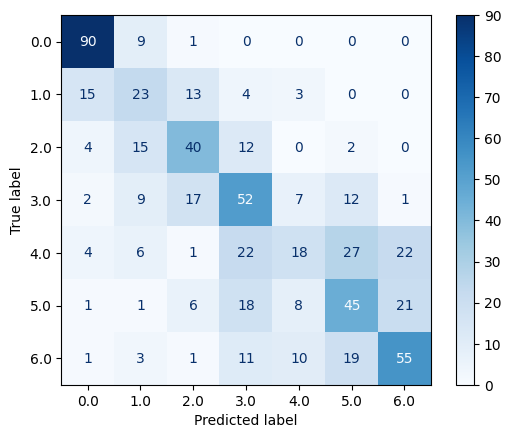

Report of Training:
              precision    recall  f1-score   support

         0.0       0.77      0.90      0.83       100
         1.0       0.35      0.40      0.37        58
         2.0       0.51      0.55      0.53        73
         3.0       0.44      0.52      0.47       100
         4.0       0.39      0.18      0.25       100
         5.0       0.43      0.45      0.44       100
         6.0       0.56      0.55      0.55       100

    accuracy                           0.51       631
   macro avg       0.49      0.51      0.49       631
weighted avg       0.50      0.51      0.50       631

21/21 [==============================] - 0s 460us/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


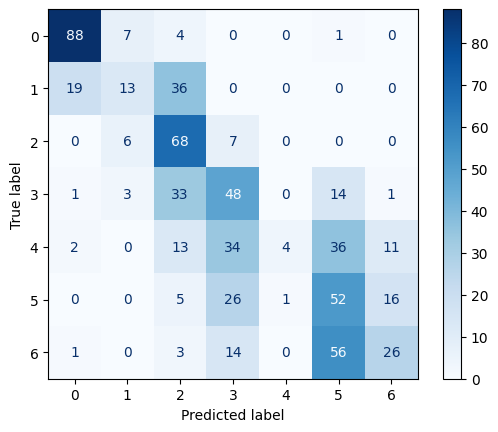

Report of Testing:
              precision    recall  f1-score   support

           0       0.79      0.88      0.83       100
           1       0.45      0.19      0.27        68
           2       0.42      0.84      0.56        81
           3       0.37      0.48      0.42       100
           4       0.80      0.04      0.08       100
           5       0.33      0.52      0.40       100
           6       0.48      0.26      0.34       100

    accuracy                           0.46       649
   macro avg       0.52      0.46      0.41       649
weighted avg       0.53      0.46      0.42       649



In [27]:
# threshold 70 with max. 100 samples and 7 classes 

# The seed value needs to be called every time so that in every cell and order the model is reproduceable
# Seed value for reproducability according to https://stackoverflow.com/questions/32419510/how-to-get-reproducible-results-in-keras
seed_value=3
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.compat.v1.set_random_seed(seed_value)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

# define the dictionaries to undersample the data for each class, then call the undersampling function
dict_under = {0: 100, 1: 68 , 2: 81, 3: 100, 4: 100, 5: 100, 6: 100}
X_under_pre, y_under_pre = undersampling(X_pre, y_pre, dict_under)
dict_under_t1 = {0: 100, 1: 58, 2: 73, 3: 100, 4: 100, 5: 100, 6: 100}
X_under_t1, y_under_t1 = undersampling(X_t1, y_t1, dict_under_t1)

# call the function start_model to initialize the model and visualize the confusion matrices
print("Train data is BigLab and test data is D1NAMO with threshold 70")
start_model(X_under_pre, y_under_pre, X_under_t1, y_under_t1, "1DCNN_Trained_BigLab_70_7", "1DCNN_Tested_D1NAMO_70_7", batchsize=16, epoch= 500)
print("Train data is D1NAMO and test data is BigLab with threshold 70")
start_model(X_under_t1, y_under_t1, X_under_pre, y_under_pre, "1DCNN_Trained_D1NAMO_70_7", "1DCNN_Tested_BigLab_70_7", batchsize=16, epoch= 500)

Train data is BigLab and test data is D1NAMO with threshold 70
Epoch 1/500


/var/folders/t1/sgksm9r9385br4pts_lckj1w0000gn/T/ipykernel_1874/2158283931.py:124: RuntimeWarning: divide by zero encountered in scalar divide
  weight_for_4 = (1/class_occurences[4]) * (total/number_classes)
/var/folders/t1/sgksm9r9385br4pts_lckj1w0000gn/T/ipykernel_1874/2158283931.py:125: RuntimeWarning: divide by zero encountered in scalar divide
  weight_for_5= (1/class_occurences[5]) * (total/number_classes)


 1/21 [>.............................] - ETA: 4s - loss: 1.6248 - sparse_categorical_accuracy: 0.2500
Epoch 1: val_loss improved from inf to 2.78592, saving model to CustomModel.weights.hdf5
21/21 [==============================] - 0s 5ms/step - loss: 1.2672 - sparse_categorical_accuracy: 0.3127 - val_loss: 2.7859 - val_sparse_categorical_accuracy: 0.3457 - lr: 0.0010
Epoch 2/500
 1/21 [>.............................] - ETA: 0s - loss: 0.9093 - sparse_categorical_accuracy: 0.6250
Epoch 2: val_loss did not improve from 2.78592
21/21 [==============================] - 0s 1ms/step - loss: 0.9744 - sparse_categorical_accuracy: 0.5232 - val_loss: 3.2561 - val_sparse_categorical_accuracy: 0.3210 - lr: 0.0010
Epoch 3/500
 1/21 [>.............................] - ETA: 0s - loss: 0.9694 - sparse_categorical_accuracy: 0.5000
Epoch 3: val_loss did not improve from 2.78592
21/21 [==============================] - 0s 1ms/step - loss: 0.9048 - sparse_categorical_accuracy: 0.5325 - val_loss: 3.5282 - 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


 1/21 [>.............................] - ETA: 0s - loss: 0.6682 - sparse_categorical_accuracy: 0.6250
Epoch 8: val_loss improved from 1.58688 to 1.38746, saving model to CustomModel.weights.hdf5
21/21 [==============================] - 0s 2ms/step - loss: 0.7338 - sparse_categorical_accuracy: 0.6161 - val_loss: 1.3875 - val_sparse_categorical_accuracy: 0.3827 - lr: 2.0000e-04
Epoch 9/500
 1/21 [>.............................] - ETA: 0s - loss: 0.8090 - sparse_categorical_accuracy: 0.7500
Epoch 9: val_loss improved from 1.38746 to 1.22245, saving model to CustomModel.weights.hdf5
21/21 [==============================] - 0s 2ms/step - loss: 0.7122 - sparse_categorical_accuracy: 0.6223 - val_loss: 1.2224 - val_sparse_categorical_accuracy: 0.4938 - lr: 2.0000e-04
Epoch 10/500
 1/21 [>.............................] - ETA: 0s - loss: 0.7328 - sparse_categorical_accuracy: 0.5000
Epoch 10: val_loss improved from 1.22245 to 1.13094, saving model to CustomModel.weights.hdf5
21/21 [==============

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 21: val_loss did not improve from 0.71189
21/21 [==============================] - 0s 1ms/step - loss: 0.5891 - sparse_categorical_accuracy: 0.6842 - val_loss: 0.8140 - val_sparse_categorical_accuracy: 0.6296 - lr: 2.0000e-04
Epoch 22/500
 1/21 [>.............................] - ETA: 0s - loss: 0.4574 - sparse_categorical_accuracy: 0.6875
Epoch 22: val_loss did not improve from 0.71189

Epoch 22: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
21/21 [==============================] - 0s 1ms/step - loss: 0.5963 - sparse_categorical_accuracy: 0.6780 - val_loss: 0.7323 - val_sparse_categorical_accuracy: 0.5926 - lr: 2.0000e-04
Epoch 23/500
 1/21 [>.............................] - ETA: 0s - loss: 0.3880 - sparse_categorical_accuracy: 0.9375
Epoch 23: val_loss did not improve from 0.71189
21/21 [==============================] - 0s 1ms/step - loss: 0.5789 - sparse_categorical_accuracy: 0.6997 - val_loss: 0.7204 - val_sparse_categorical_accuracy: 0.6296 - lr: 4.000

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 29: val_loss did not improve from 0.66485
21/21 [==============================] - 0s 1ms/step - loss: 0.5893 - sparse_categorical_accuracy: 0.6471 - val_loss: 0.6727 - val_sparse_categorical_accuracy: 0.7160 - lr: 4.0000e-05
Epoch 30/500
 1/21 [>.............................] - ETA: 0s - loss: 0.4474 - sparse_categorical_accuracy: 0.6875
Epoch 30: val_loss did not improve from 0.66485

Epoch 30: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.
21/21 [==============================] - 0s 2ms/step - loss: 0.5302 - sparse_categorical_accuracy: 0.7121 - val_loss: 0.6709 - val_sparse_categorical_accuracy: 0.7284 - lr: 4.0000e-05
Epoch 31/500
 1/21 [>.............................] - ETA: 0s - loss: 0.6215 - sparse_categorical_accuracy: 0.6250Restoring model weights from the end of the best epoch: 21.

Epoch 31: val_loss did not improve from 0.66485
21/21 [==============================] - 0s 1ms/step - loss: 0.5668 - sparse_categorical_accuracy: 0.6935 - val_loss: 0

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 27: val_loss did not improve from 0.61390
21/21 [==============================] - 0s 1ms/step - loss: 0.6004 - sparse_categorical_accuracy: 0.6512 - val_loss: 0.6180 - val_sparse_categorical_accuracy: 0.7531 - lr: 2.0000e-04
Epoch 28/500
 1/21 [>.............................] - ETA: 0s - loss: 0.4715 - sparse_categorical_accuracy: 0.8125
Epoch 28: val_loss improved from 0.61390 to 0.61049, saving model to CustomModel.weights.hdf5
21/21 [==============================] - 0s 2ms/step - loss: 0.5844 - sparse_categorical_accuracy: 0.6543 - val_loss: 0.6105 - val_sparse_categorical_accuracy: 0.7778 - lr: 2.0000e-04
Epoch 29/500
 1/21 [>.............................] - ETA: 0s - loss: 0.6273 - sparse_categorical_accuracy: 0.5625
Epoch 29: val_loss did not improve from 0.61049
21/21 [==============================] - 0s 1ms/step - loss: 0.6529 - sparse_categorical_accuracy: 0.6327 - val_loss: 0.6795 - val_sparse_categorical_accuracy: 0.7284 - lr: 2.0000e-04
Epoch 30/500
 1/21 [>......

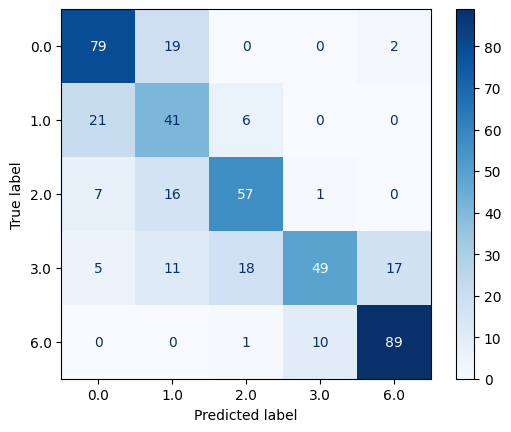

Report of Training:
              precision    recall  f1-score   support

         0.0       0.71      0.79      0.75       100
         1.0       0.47      0.60      0.53        68
         2.0       0.70      0.70      0.70        81
         3.0       0.82      0.49      0.61       100
         6.0       0.82      0.89      0.86       100

    accuracy                           0.70       449
   macro avg       0.70      0.70      0.69       449
weighted avg       0.72      0.70      0.70       449

14/14 [==============================] - 0s 453us/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


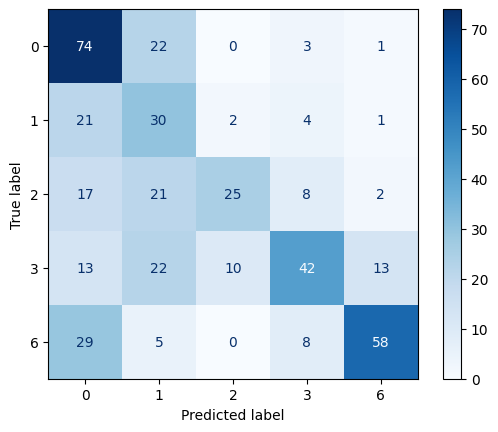

Report of Testing:
              precision    recall  f1-score   support

           0       0.48      0.74      0.58       100
           1       0.30      0.52      0.38        58
           2       0.68      0.34      0.45        73
           3       0.65      0.42      0.51       100
           6       0.77      0.58      0.66       100

    accuracy                           0.53       431
   macro avg       0.58      0.52      0.52       431
weighted avg       0.60      0.53      0.54       431

Train data is D1NAMO and test data is BigLab with threshold 70


/var/folders/t1/sgksm9r9385br4pts_lckj1w0000gn/T/ipykernel_1874/2158283931.py:124: RuntimeWarning: divide by zero encountered in scalar divide
  weight_for_4 = (1/class_occurences[4]) * (total/number_classes)
/var/folders/t1/sgksm9r9385br4pts_lckj1w0000gn/T/ipykernel_1874/2158283931.py:125: RuntimeWarning: divide by zero encountered in scalar divide
  weight_for_5= (1/class_occurences[5]) * (total/number_classes)


Epoch 1/500
 1/20 [>.............................] - ETA: 4s - loss: 1.2840 - sparse_categorical_accuracy: 0.2500
Epoch 1: val_loss improved from inf to 3.22946, saving model to CustomModel.weights.hdf5
20/20 [==============================] - 0s 5ms/step - loss: 1.2281 - sparse_categorical_accuracy: 0.4369 - val_loss: 3.2295 - val_sparse_categorical_accuracy: 0.3077 - lr: 0.0010
Epoch 2/500
 1/20 [>.............................] - ETA: 0s - loss: 0.9411 - sparse_categorical_accuracy: 0.5000
Epoch 2: val_loss improved from 3.22946 to 2.62706, saving model to CustomModel.weights.hdf5
20/20 [==============================] - 0s 2ms/step - loss: 1.0638 - sparse_categorical_accuracy: 0.5049 - val_loss: 2.6271 - val_sparse_categorical_accuracy: 0.2949 - lr: 0.0010
Epoch 3/500
 1/20 [>.............................] - ETA: 0s - loss: 0.7573 - sparse_categorical_accuracy: 0.5625
Epoch 3: val_loss improved from 2.62706 to 1.86760, saving model to CustomModel.weights.hdf5
20/20 [================

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 7: val_loss improved from 1.31862 to 1.11603, saving model to CustomModel.weights.hdf5
20/20 [==============================] - 0s 2ms/step - loss: 0.7225 - sparse_categorical_accuracy: 0.6278 - val_loss: 1.1160 - val_sparse_categorical_accuracy: 0.5513 - lr: 0.0010
Epoch 8/500
 1/20 [>.............................] - ETA: 0s - loss: 0.8626 - sparse_categorical_accuracy: 0.4375
Epoch 8: val_loss improved from 1.11603 to 1.04739, saving model to CustomModel.weights.hdf5
20/20 [==============================] - 0s 2ms/step - loss: 0.7188 - sparse_categorical_accuracy: 0.5987 - val_loss: 1.0474 - val_sparse_categorical_accuracy: 0.5385 - lr: 0.0010
Epoch 9/500
 1/20 [>.............................] - ETA: 0s - loss: 0.7298 - sparse_categorical_accuracy: 0.5625
Epoch 9: val_loss improved from 1.04739 to 1.01752, saving model to CustomModel.weights.hdf5
20/20 [==============================] - 0s 2ms/step - loss: 0.7287 - sparse_categorical_accuracy: 0.5922 - val_loss: 1.0175 - val_s

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 25: val_loss did not improve from 0.76320
20/20 [==============================] - 0s 2ms/step - loss: 0.5654 - sparse_categorical_accuracy: 0.6935 - val_loss: 0.7663 - val_sparse_categorical_accuracy: 0.7179 - lr: 4.0000e-05
Epoch 26/500
 1/20 [>.............................] - ETA: 0s - loss: 0.6378 - sparse_categorical_accuracy: 0.6250
Epoch 26: val_loss did not improve from 0.76320
20/20 [==============================] - 0s 1ms/step - loss: 0.5516 - sparse_categorical_accuracy: 0.7161 - val_loss: 0.7681 - val_sparse_categorical_accuracy: 0.7051 - lr: 4.0000e-05
Epoch 27/500
 1/20 [>.............................] - ETA: 0s - loss: 0.4636 - sparse_categorical_accuracy: 0.6875
Epoch 27: val_loss did not improve from 0.76320

Epoch 27: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.
20/20 [==============================] - 0s 1ms/step - loss: 0.5672 - sparse_categorical_accuracy: 0.7000 - val_loss: 0.7695 - val_sparse_categorical_accuracy: 0.7051 - lr: 4.0000

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 24: val_loss did not improve from 0.71903
20/20 [==============================] - 0s 2ms/step - loss: 0.6077 - sparse_categorical_accuracy: 0.6387 - val_loss: 0.7296 - val_sparse_categorical_accuracy: 0.7436 - lr: 4.0000e-05
Epoch 25/500
 1/20 [>.............................] - ETA: 0s - loss: 0.5233 - sparse_categorical_accuracy: 0.6875
Epoch 25: val_loss did not improve from 0.71903
20/20 [==============================] - 0s 1ms/step - loss: 0.6244 - sparse_categorical_accuracy: 0.6677 - val_loss: 0.7249 - val_sparse_categorical_accuracy: 0.7436 - lr: 4.0000e-05
Epoch 26/500
 1/20 [>.............................] - ETA: 0s - loss: 0.6681 - sparse_categorical_accuracy: 0.7500
Epoch 26: val_loss did not improve from 0.71903

Epoch 26: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.
20/20 [==============================] - 0s 1ms/step - loss: 0.6511 - sparse_categorical_accuracy: 0.6516 - val_loss: 0.7278 - val_sparse_categorical_accuracy: 0.7564 - lr: 4.0000

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 30: val_loss did not improve from 0.71088
20/20 [==============================] - 0s 1ms/step - loss: 0.6388 - sparse_categorical_accuracy: 0.6484 - val_loss: 0.7340 - val_sparse_categorical_accuracy: 0.7179 - lr: 8.0000e-06
Epoch 31/500
 1/20 [>.............................] - ETA: 0s - loss: 0.6427 - sparse_categorical_accuracy: 0.6250
Epoch 31: val_loss did not improve from 0.71088

Epoch 31: ReduceLROnPlateau reducing learning rate to 1.6000001778593287e-06.
20/20 [==============================] - 0s 1ms/step - loss: 0.5524 - sparse_categorical_accuracy: 0.7032 - val_loss: 0.7375 - val_sparse_categorical_accuracy: 0.7179 - lr: 8.0000e-06
Epoch 32/500
 1/20 [>.............................] - ETA: 0s - loss: 0.6166 - sparse_categorical_accuracy: 0.6250Restoring model weights from the end of the best epoch: 22.

Epoch 32: val_loss did not improve from 0.71088
20/20 [==============================] - 0s 1ms/step - loss: 0.5999 - sparse_categorical_accuracy: 0.6581 - val_loss: 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 26: val_loss did not improve from 0.66992
20/20 [==============================] - 0s 1ms/step - loss: 0.5758 - sparse_categorical_accuracy: 0.6742 - val_loss: 0.6864 - val_sparse_categorical_accuracy: 0.7308 - lr: 2.0000e-04
Epoch 27/500
 1/20 [>.............................] - ETA: 0s - loss: 0.4307 - sparse_categorical_accuracy: 0.7500
Epoch 27: val_loss did not improve from 0.66992

Epoch 27: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
20/20 [==============================] - 0s 2ms/step - loss: 0.5646 - sparse_categorical_accuracy: 0.6839 - val_loss: 0.6829 - val_sparse_categorical_accuracy: 0.7308 - lr: 2.0000e-04
Epoch 28/500
 1/20 [>.............................] - ETA: 0s - loss: 0.5978 - sparse_categorical_accuracy: 0.6250
Epoch 28: val_loss did not improve from 0.66992
20/20 [==============================] - 0s 1ms/step - loss: 0.5770 - sparse_categorical_accuracy: 0.6774 - val_loss: 0.6859 - val_sparse_categorical_accuracy: 0.7179 - lr: 4.000

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


20/20 [==============================] - 0s 2ms/step - loss: 0.5476 - sparse_categorical_accuracy: 0.7032 - val_loss: 0.6529 - val_sparse_categorical_accuracy: 0.6923 - lr: 4.0000e-05
Epoch 38/500
 1/20 [>.............................] - ETA: 0s - loss: 0.6410 - sparse_categorical_accuracy: 0.6250
Epoch 38: val_loss improved from 0.65289 to 0.64868, saving model to CustomModel.weights.hdf5
20/20 [==============================] - 0s 2ms/step - loss: 0.6002 - sparse_categorical_accuracy: 0.6677 - val_loss: 0.6487 - val_sparse_categorical_accuracy: 0.7179 - lr: 4.0000e-05
Epoch 39/500
 1/20 [>.............................] - ETA: 0s - loss: 0.7935 - sparse_categorical_accuracy: 0.6250
Epoch 39: val_loss did not improve from 0.64868
20/20 [==============================] - 0s 1ms/step - loss: 0.5998 - sparse_categorical_accuracy: 0.7032 - val_loss: 0.6503 - val_sparse_categorical_accuracy: 0.7308 - lr: 4.0000e-05
Epoch 40/500
 1/20 [>.............................] - ETA: 0s - loss: 0.6494

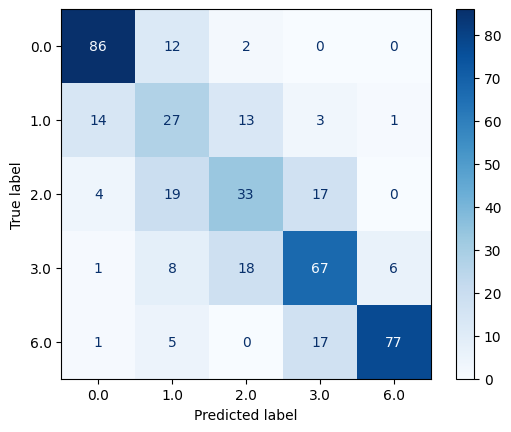

Report of Training:
              precision    recall  f1-score   support

         0.0       0.81      0.86      0.83       100
         1.0       0.38      0.47      0.42        58
         2.0       0.50      0.45      0.47        73
         3.0       0.64      0.67      0.66       100
         6.0       0.92      0.77      0.84       100

    accuracy                           0.67       431
   macro avg       0.65      0.64      0.64       431
weighted avg       0.69      0.67      0.68       431

15/15 [==============================] - 0s 410us/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


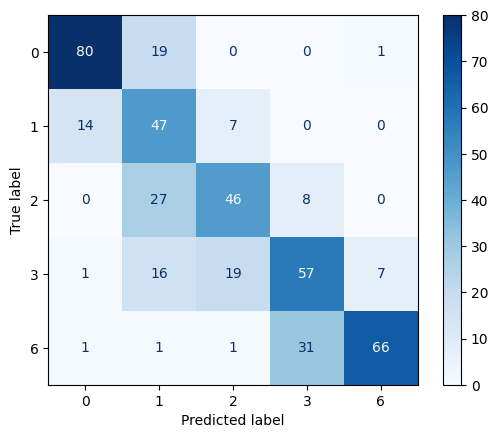

Report of Testing:
              precision    recall  f1-score   support

           0       0.83      0.80      0.82       100
           1       0.43      0.69      0.53        68
           2       0.63      0.57      0.60        81
           3       0.59      0.57      0.58       100
           6       0.89      0.66      0.76       100

    accuracy                           0.66       449
   macro avg       0.68      0.66      0.66       449
weighted avg       0.69      0.66      0.67       449



In [46]:
# threshold 70 with 100 samples and 5 classes

# The seed value needs to be called every time so that in every cell and order the model is reproduceable
# Seed value for reproducability according to https://stackoverflow.com/questions/32419510/how-to-get-reproducible-results-in-keras
seed_value=3
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.compat.v1.set_random_seed(seed_value)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

# define the dictionaries to undersample the data for each class, then call the undersampling function
dict_under = {0: 100, 1: 68 , 2: 81, 3: 100, 4: 0, 5: 0, 6: 100}
X_under_pre, y_under_pre = undersampling(X_pre, y_pre, dict_under)
dict_under_t1 = {0: 100, 1: 58, 2: 73, 3: 100, 4: 0, 5: 0, 6: 100}
X_under_t1, y_under_t1 = undersampling(X_t1, y_t1, dict_under_t1)

# call the function start_model to initialize the model and visualize the confusion matrices
print("Train data is BigLab and test data is D1NAMO with threshold 70")
start_model(X_under_pre, y_under_pre, X_under_t1, y_under_t1, "1DCNN_Trained_BigLab_70", "1DCNN_Tested_D1NAMO_70", batchsize=16, epoch= 500)
print("Train data is D1NAMO and test data is BigLab with threshold 70")
start_model(X_under_t1, y_under_t1, X_under_pre, y_under_pre, "1DCNN_Trained_D1NAMO_70", "1DCNN_Tested_BigLab_70", batchsize=16, epoch= 500)

Train data is BigLab and test data is D1NAMO with threshold 70
Epoch 1/500


/var/folders/t1/sgksm9r9385br4pts_lckj1w0000gn/T/ipykernel_1874/3598073534.py:131: RuntimeWarning: divide by zero encountered in scalar divide
  weight_for_4 = (1/class_occurences[4]) * (total/number_classes)
/var/folders/t1/sgksm9r9385br4pts_lckj1w0000gn/T/ipykernel_1874/3598073534.py:132: RuntimeWarning: divide by zero encountered in scalar divide
  weight_for_5= (1/class_occurences[5]) * (total/number_classes)


 1/16 [>.............................] - ETA: 3s - loss: 1.7675 - sparse_categorical_accuracy: 0.1250
Epoch 1: val_loss improved from inf to 3.27978, saving model to CustomModel.weights.hdf5
16/16 [==============================] - 0s 6ms/step - loss: 1.3011 - sparse_categorical_accuracy: 0.2748 - val_loss: 3.2798 - val_sparse_categorical_accuracy: 0.2066 - lr: 0.0010
Epoch 2/500
 1/16 [>.............................] - ETA: 0s - loss: 1.0154 - sparse_categorical_accuracy: 0.5312
Epoch 2: val_loss did not improve from 3.27978
16/16 [==============================] - 0s 2ms/step - loss: 1.0334 - sparse_categorical_accuracy: 0.5455 - val_loss: 3.4224 - val_sparse_categorical_accuracy: 0.4132 - lr: 0.0010
Epoch 3/500
 1/16 [>.............................] - ETA: 0s - loss: 0.9748 - sparse_categorical_accuracy: 0.5938
Epoch 3: val_loss did not improve from 3.27978
16/16 [==============================] - 0s 2ms/step - loss: 0.9053 - sparse_categorical_accuracy: 0.5702 - val_loss: 4.6635 - 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 8: val_loss improved from 1.61209 to 1.40851, saving model to CustomModel.weights.hdf5
16/16 [==============================] - 0s 2ms/step - loss: 0.7799 - sparse_categorical_accuracy: 0.6136 - val_loss: 1.4085 - val_sparse_categorical_accuracy: 0.4215 - lr: 2.0000e-04
Epoch 9/500
 1/16 [>.............................] - ETA: 0s - loss: 0.4608 - sparse_categorical_accuracy: 0.8125
Epoch 9: val_loss improved from 1.40851 to 1.22237, saving model to CustomModel.weights.hdf5
16/16 [==============================] - 0s 2ms/step - loss: 0.7674 - sparse_categorical_accuracy: 0.6488 - val_loss: 1.2224 - val_sparse_categorical_accuracy: 0.4876 - lr: 2.0000e-04
Epoch 10/500
 1/16 [>.............................] - ETA: 0s - loss: 0.7079 - sparse_categorical_accuracy: 0.5938
Epoch 10: val_loss improved from 1.22237 to 1.14648, saving model to CustomModel.weights.hdf5
16/16 [==============================] - 0s 2ms/step - loss: 0.7147 - sparse_categorical_accuracy: 0.6550 - val_loss: 1.14

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


16/16 [==============================] - 0s 2ms/step - loss: 0.5234 - sparse_categorical_accuracy: 0.7190 - val_loss: 0.6774 - val_sparse_categorical_accuracy: 0.7355 - lr: 4.0000e-05
Epoch 29/500
 1/16 [>.............................] - ETA: 0s - loss: 0.3600 - sparse_categorical_accuracy: 0.8125
Epoch 29: val_loss improved from 0.67742 to 0.66280, saving model to CustomModel.weights.hdf5
16/16 [==============================] - 0s 2ms/step - loss: 0.5927 - sparse_categorical_accuracy: 0.6818 - val_loss: 0.6628 - val_sparse_categorical_accuracy: 0.7355 - lr: 4.0000e-05
Epoch 30/500
 1/16 [>.............................] - ETA: 0s - loss: 0.4078 - sparse_categorical_accuracy: 0.8438
Epoch 30: val_loss improved from 0.66280 to 0.65044, saving model to CustomModel.weights.hdf5
16/16 [==============================] - 0s 2ms/step - loss: 0.5195 - sparse_categorical_accuracy: 0.7211 - val_loss: 0.6504 - val_sparse_categorical_accuracy: 0.7603 - lr: 4.0000e-05
Epoch 31/500
 1/16 [>.........

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 29: val_loss did not improve from 0.59172
16/16 [==============================] - 0s 1ms/step - loss: 0.5614 - sparse_categorical_accuracy: 0.7314 - val_loss: 0.6169 - val_sparse_categorical_accuracy: 0.7213 - lr: 2.0000e-04
Epoch 30/500
 1/16 [>.............................] - ETA: 0s - loss: 0.9027 - sparse_categorical_accuracy: 0.5938
Epoch 30: val_loss did not improve from 0.59172
16/16 [==============================] - 0s 1ms/step - loss: 0.5368 - sparse_categorical_accuracy: 0.6963 - val_loss: 0.6050 - val_sparse_categorical_accuracy: 0.7377 - lr: 2.0000e-04
Epoch 31/500
 1/16 [>.............................] - ETA: 0s - loss: 0.5117 - sparse_categorical_accuracy: 0.6250
Epoch 31: val_loss did not improve from 0.59172

Epoch 31: ReduceLROnPlateau reducing learning rate to 4.0000001899898055e-05.
16/16 [==============================] - 0s 1ms/step - loss: 0.5500 - sparse_categorical_accuracy: 0.7025 - val_loss: 0.6048 - val_sparse_categorical_accuracy: 0.7377 - lr: 2.000

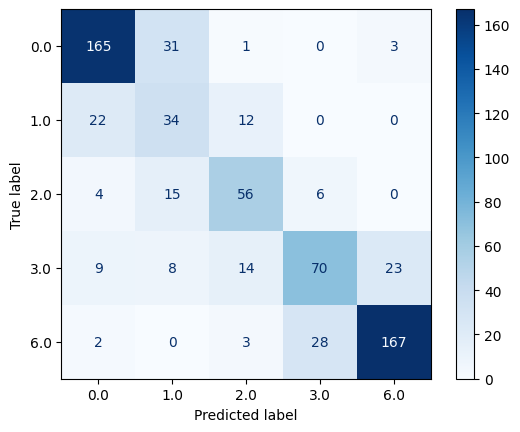

Report of Training:
              precision    recall  f1-score   support

         0.0       0.82      0.82      0.82       200
         1.0       0.39      0.50      0.44        68
         2.0       0.65      0.69      0.67        81
         3.0       0.67      0.56      0.61       124
         6.0       0.87      0.83      0.85       200

    accuracy                           0.73       673
   macro avg       0.68      0.68      0.68       673
weighted avg       0.74      0.73      0.73       673

21/21 [==============================] - 0s 367us/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


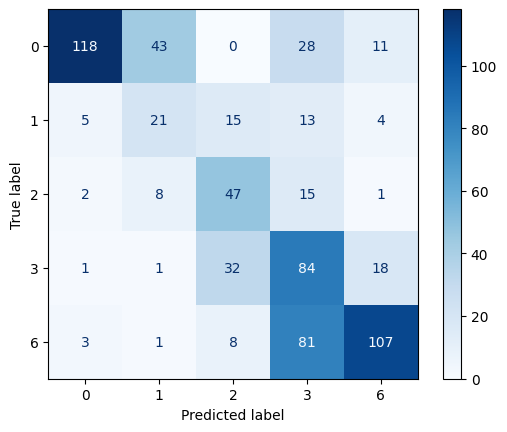

Report of Testing:
              precision    recall  f1-score   support

           0       0.91      0.59      0.72       200
           1       0.28      0.36      0.32        58
           2       0.46      0.64      0.54        73
           3       0.38      0.62      0.47       136
           6       0.76      0.54      0.63       200

    accuracy                           0.57       667
   macro avg       0.56      0.55      0.53       667
weighted avg       0.65      0.57      0.59       667

Train data is D1NAMO and test data is BigLab with threshold 70


/var/folders/t1/sgksm9r9385br4pts_lckj1w0000gn/T/ipykernel_1874/3598073534.py:131: RuntimeWarning: divide by zero encountered in scalar divide
  weight_for_4 = (1/class_occurences[4]) * (total/number_classes)
/var/folders/t1/sgksm9r9385br4pts_lckj1w0000gn/T/ipykernel_1874/3598073534.py:132: RuntimeWarning: divide by zero encountered in scalar divide
  weight_for_5= (1/class_occurences[5]) * (total/number_classes)


Epoch 1/500
 1/15 [=>............................] - ETA: 2s - loss: 1.3478 - sparse_categorical_accuracy: 0.2812
Epoch 1: val_loss improved from inf to 3.11966, saving model to CustomModel.weights.hdf5
15/15 [==============================] - 0s 6ms/step - loss: 1.3085 - sparse_categorical_accuracy: 0.4333 - val_loss: 3.1197 - val_sparse_categorical_accuracy: 0.2833 - lr: 0.0010
Epoch 2/500
 1/15 [=>............................] - ETA: 0s - loss: 1.3039 - sparse_categorical_accuracy: 0.4688
Epoch 2: val_loss did not improve from 3.11966
15/15 [==============================] - 0s 2ms/step - loss: 1.1271 - sparse_categorical_accuracy: 0.5292 - val_loss: 3.1447 - val_sparse_categorical_accuracy: 0.2750 - lr: 0.0010
Epoch 3/500
 1/15 [=>............................] - ETA: 0s - loss: 0.9659 - sparse_categorical_accuracy: 0.7500
Epoch 3: val_loss improved from 3.11966 to 2.41633, saving model to CustomModel.weights.hdf5
15/15 [==============================] - 0s 2ms/step - loss: 1.0188 -

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


15/15 [==============================] - 0s 2ms/step - loss: 0.7511 - sparse_categorical_accuracy: 0.6479 - val_loss: 1.1357 - val_sparse_categorical_accuracy: 0.5583 - lr: 0.0010
Epoch 9/500
 1/15 [=>............................] - ETA: 0s - loss: 0.6091 - sparse_categorical_accuracy: 0.8125
Epoch 9: val_loss improved from 1.13574 to 1.10970, saving model to CustomModel.weights.hdf5
15/15 [==============================] - 0s 3ms/step - loss: 0.7539 - sparse_categorical_accuracy: 0.6854 - val_loss: 1.1097 - val_sparse_categorical_accuracy: 0.5167 - lr: 0.0010
Epoch 10/500
 1/15 [=>............................] - ETA: 0s - loss: 0.8019 - sparse_categorical_accuracy: 0.5938
Epoch 10: val_loss improved from 1.10970 to 0.90318, saving model to CustomModel.weights.hdf5
15/15 [==============================] - 0s 2ms/step - loss: 0.7218 - sparse_categorical_accuracy: 0.6521 - val_loss: 0.9032 - val_sparse_categorical_accuracy: 0.6417 - lr: 0.0010
Epoch 11/500
 1/15 [=>......................

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 63: val_loss did not improve from 0.70521
15/15 [==============================] - 0s 2ms/step - loss: 0.5918 - sparse_categorical_accuracy: 0.7208 - val_loss: 0.7073 - val_sparse_categorical_accuracy: 0.7583 - lr: 4.0000e-05
Epoch 64/500
 1/15 [=>............................] - ETA: 0s - loss: 0.4207 - sparse_categorical_accuracy: 0.8438
Epoch 64: val_loss did not improve from 0.70521

Epoch 64: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.
15/15 [==============================] - 0s 1ms/step - loss: 0.6007 - sparse_categorical_accuracy: 0.7063 - val_loss: 0.7070 - val_sparse_categorical_accuracy: 0.7583 - lr: 4.0000e-05
Epoch 65/500
 1/15 [=>............................] - ETA: 0s - loss: 0.4297 - sparse_categorical_accuracy: 0.7500
Epoch 65: val_loss did not improve from 0.70521
15/15 [==============================] - 0s 1ms/step - loss: 0.6151 - sparse_categorical_accuracy: 0.6833 - val_loss: 0.7055 - val_sparse_categorical_accuracy: 0.7583 - lr: 8.0000

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 62: val_loss improved from 0.69210 to 0.69130, saving model to CustomModel.weights.hdf5
15/15 [==============================] - 0s 2ms/step - loss: 0.5639 - sparse_categorical_accuracy: 0.7229 - val_loss: 0.6913 - val_sparse_categorical_accuracy: 0.7083 - lr: 8.0000e-06
Epoch 63/500
 1/15 [=>............................] - ETA: 0s - loss: 0.4953 - sparse_categorical_accuracy: 0.8750
Epoch 63: val_loss improved from 0.69130 to 0.69062, saving model to CustomModel.weights.hdf5
15/15 [==============================] - 0s 2ms/step - loss: 0.5449 - sparse_categorical_accuracy: 0.7583 - val_loss: 0.6906 - val_sparse_categorical_accuracy: 0.7083 - lr: 8.0000e-06
Epoch 64/500
 1/15 [=>............................] - ETA: 0s - loss: 0.3918 - sparse_categorical_accuracy: 0.8438
Epoch 64: val_loss improved from 0.69062 to 0.69041, saving model to CustomModel.weights.hdf5
15/15 [==============================] - 0s 2ms/step - loss: 0.5791 - sparse_categorical_accuracy: 0.7333 - val_loss: 0

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 23: val_loss did not improve from 0.56774
15/15 [==============================] - 0s 1ms/step - loss: 0.5873 - sparse_categorical_accuracy: 0.6917 - val_loss: 0.5814 - val_sparse_categorical_accuracy: 0.7750 - lr: 0.0010
Epoch 24/500
 1/15 [=>............................] - ETA: 0s - loss: 0.4197 - sparse_categorical_accuracy: 0.6875
Epoch 24: val_loss did not improve from 0.56774
15/15 [==============================] - 0s 1ms/step - loss: 0.5680 - sparse_categorical_accuracy: 0.7312 - val_loss: 0.7014 - val_sparse_categorical_accuracy: 0.7250 - lr: 0.0010
Epoch 25/500
 1/15 [=>............................] - ETA: 0s - loss: 0.5256 - sparse_categorical_accuracy: 0.8438
Epoch 25: val_loss did not improve from 0.56774

Epoch 25: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
15/15 [==============================] - 0s 2ms/step - loss: 0.5930 - sparse_categorical_accuracy: 0.7354 - val_loss: 0.6562 - val_sparse_categorical_accuracy: 0.7583 - lr: 0.0010
Epoch 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 40: val_loss did not improve from 0.55915

Epoch 40: ReduceLROnPlateau reducing learning rate to 1.6000001778593287e-06.
15/15 [==============================] - 0s 2ms/step - loss: 0.4809 - sparse_categorical_accuracy: 0.7812 - val_loss: 0.5692 - val_sparse_categorical_accuracy: 0.7667 - lr: 8.0000e-06
Epoch 41/500
 1/15 [=>............................] - ETA: 0s - loss: 0.3699 - sparse_categorical_accuracy: 0.8125Restoring model weights from the end of the best epoch: 31.

Epoch 41: val_loss did not improve from 0.55915
15/15 [==============================] - 0s 2ms/step - loss: 0.5224 - sparse_categorical_accuracy: 0.7500 - val_loss: 0.5696 - val_sparse_categorical_accuracy: 0.7583 - lr: 1.6000e-06
Epoch 41: early stopping
3/3 [==============================] - 0s 726us/step
Epoch 1/500
 1/15 [=>............................] - ETA: 2s - loss: 1.4174 - sparse_categorical_accuracy: 0.0938
Epoch 1: val_loss did not improve from 0.55915
15/15 [==============================] - 0

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


15/15 [==============================] - 0s 2ms/step - loss: 0.5275 - sparse_categorical_accuracy: 0.7500 - val_loss: 0.5124 - val_sparse_categorical_accuracy: 0.8083 - lr: 2.0000e-04
Epoch 41/500
 1/15 [=>............................] - ETA: 0s - loss: 0.3433 - sparse_categorical_accuracy: 0.8438
Epoch 41: val_loss did not improve from 0.51239
15/15 [==============================] - 0s 1ms/step - loss: 0.5047 - sparse_categorical_accuracy: 0.7604 - val_loss: 0.5196 - val_sparse_categorical_accuracy: 0.7833 - lr: 2.0000e-04
Epoch 42/500
 1/15 [=>............................] - ETA: 0s - loss: 0.5002 - sparse_categorical_accuracy: 0.7812
Epoch 42: val_loss did not improve from 0.51239
15/15 [==============================] - 0s 1ms/step - loss: 0.5095 - sparse_categorical_accuracy: 0.7521 - val_loss: 0.5214 - val_sparse_categorical_accuracy: 0.7917 - lr: 2.0000e-04
Epoch 43/500
 1/15 [=>............................] - ETA: 0s - loss: 0.4381 - sparse_categorical_accuracy: 0.7812
Epoch 4

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 38: val_loss did not improve from 0.47689
15/15 [==============================] - 0s 1ms/step - loss: 0.4997 - sparse_categorical_accuracy: 0.7500 - val_loss: 0.5036 - val_sparse_categorical_accuracy: 0.8017 - lr: 4.0000e-05
Epoch 39/500
 1/15 [=>............................] - ETA: 0s - loss: 0.6279 - sparse_categorical_accuracy: 0.8438
Epoch 39: val_loss did not improve from 0.47689

Epoch 39: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.
15/15 [==============================] - 0s 2ms/step - loss: 0.4756 - sparse_categorical_accuracy: 0.7708 - val_loss: 0.5079 - val_sparse_categorical_accuracy: 0.8099 - lr: 4.0000e-05
Epoch 40/500
 1/15 [=>............................] - ETA: 0s - loss: 0.6923 - sparse_categorical_accuracy: 0.7500
Epoch 40: val_loss did not improve from 0.47689
15/15 [==============================] - 0s 2ms/step - loss: 0.5179 - sparse_categorical_accuracy: 0.7563 - val_loss: 0.5090 - val_sparse_categorical_accuracy: 0.7934 - lr: 8.0000

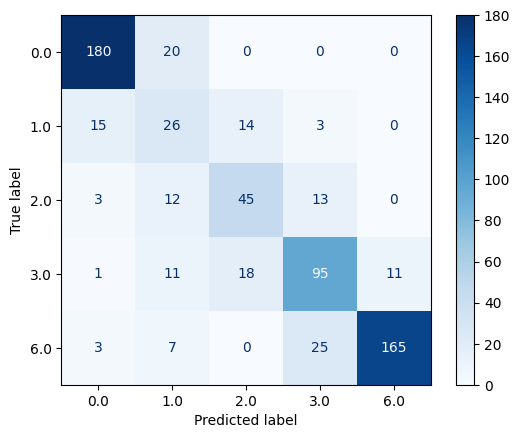

Report of Training:
              precision    recall  f1-score   support

         0.0       0.89      0.90      0.90       200
         1.0       0.34      0.45      0.39        58
         2.0       0.58      0.62      0.60        73
         3.0       0.70      0.70      0.70       136
         6.0       0.94      0.82      0.88       200

    accuracy                           0.77       667
   macro avg       0.69      0.70      0.69       667
weighted avg       0.78      0.77      0.77       667

22/22 [==============================] - 0s 397us/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Report of Testing:
              precision    recall  f1-score   support

           0       0.84      0.95      0.89       200
           1       0.53      0.59      0.56        68
           2       0.68      0.33      0.45        81
           3       0.51      0.69      0.58       124
           6       0.91      0.75      0.82       200

    accuracy                           0.73       673
   macro avg       0.69      0.66      0.66       673
weighted avg       0.75      0.73      0.73       673



In [29]:
# Threshold 70 with sampling 200 and 5 classes

# The seed value needs to be called every time so that in every cell and order the model is reproduceable
# Seed value for reproducability according to https://stackoverflow.com/questions/32419510/how-to-get-reproducible-results-in-keras
seed_value=3
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.compat.v1.set_random_seed(seed_value)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

# define the dictionaries to undersample the data for each class, then call the undersampling function
dict_under ={0: 200, 1: 68 , 2: 81, 3: 124, 4: 0, 5: 0, 6: 200}
X_under_pre, y_under_pre = undersampling(X_pre, y_pre, dict_under)
dict_under_t1 ={0: 200, 1: 58, 2: 73, 3: 136, 4: 0, 5: 0, 6: 200}
X_under_t1, y_under_t1 = undersampling(X_t1, y_t1, dict_under_t1)

# call the function start_model to initialize the model and visualize the confusion matrices
print("Train data is BigLab and test data is D1NAMO with threshold 70")
start_model(X_under_pre, y_under_pre, X_under_t1, y_under_t1, "1DCNN_Trained_BigLab_70_200", "1DCNN_Tested_D1NAMO_70_200", batchsize=32, epoch= 500)
print("Train data is D1NAMO and test data is BigLab with threshold 70")
start_model(X_under_t1, y_under_t1, X_under_pre, y_under_pre, "1DCNN_Trained_D1NAMO_70_200", "1DCNN_Tested_BigLab_70_200", batchsize=32, epoch= 500)


Train data is BigLab and test data is D1NAMO with threshold 70
Epoch 1/500


/var/folders/t1/sgksm9r9385br4pts_lckj1w0000gn/T/ipykernel_1874/3598073534.py:131: RuntimeWarning: divide by zero encountered in scalar divide
  weight_for_4 = (1/class_occurences[4]) * (total/number_classes)
/var/folders/t1/sgksm9r9385br4pts_lckj1w0000gn/T/ipykernel_1874/3598073534.py:132: RuntimeWarning: divide by zero encountered in scalar divide
  weight_for_5= (1/class_occurences[5]) * (total/number_classes)


 1/20 [>.............................] - ETA: 4s - loss: 1.7494 - sparse_categorical_accuracy: 0.0800
Epoch 1: val_loss improved from inf to 3.29571, saving model to CustomModel.weights.hdf5
20/20 [==============================] - 0s 5ms/step - loss: 1.2911 - sparse_categorical_accuracy: 0.3161 - val_loss: 3.2957 - val_sparse_categorical_accuracy: 0.3967 - lr: 0.0010
Epoch 2/500
 1/20 [>.............................] - ETA: 0s - loss: 0.9470 - sparse_categorical_accuracy: 0.5200
Epoch 2: val_loss did not improve from 3.29571
20/20 [==============================] - 0s 1ms/step - loss: 0.9954 - sparse_categorical_accuracy: 0.5744 - val_loss: 3.5882 - val_sparse_categorical_accuracy: 0.3967 - lr: 0.0010
Epoch 3/500
 1/20 [>.............................] - ETA: 0s - loss: 1.0281 - sparse_categorical_accuracy: 0.5600
Epoch 3: val_loss did not improve from 3.29571
20/20 [==============================] - 0s 2ms/step - loss: 0.8934 - sparse_categorical_accuracy: 0.5331 - val_loss: 3.3397 - 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 8: val_loss improved from 1.21983 to 1.16855, saving model to CustomModel.weights.hdf5
20/20 [==============================] - 0s 2ms/step - loss: 0.6781 - sparse_categorical_accuracy: 0.6736 - val_loss: 1.1686 - val_sparse_categorical_accuracy: 0.5455 - lr: 0.0010
Epoch 9/500
 1/20 [>.............................] - ETA: 0s - loss: 0.3451 - sparse_categorical_accuracy: 0.8400
Epoch 9: val_loss improved from 1.16855 to 0.84113, saving model to CustomModel.weights.hdf5
20/20 [==============================] - 0s 1ms/step - loss: 0.6630 - sparse_categorical_accuracy: 0.6880 - val_loss: 0.8411 - val_sparse_categorical_accuracy: 0.6860 - lr: 0.0010
Epoch 10/500
 1/20 [>.............................] - ETA: 0s - loss: 0.6217 - sparse_categorical_accuracy: 0.6400
Epoch 10: val_loss did not improve from 0.84113
20/20 [==============================] - 0s 1ms/step - loss: 0.5946 - sparse_categorical_accuracy: 0.6756 - val_loss: 1.1806 - val_sparse_categorical_accuracy: 0.5537 - lr: 0.0

Report of Training:
              precision    recall  f1-score   support

         0.0       0.84      0.84      0.84       200
         1.0       0.38      0.53      0.44        68
         2.0       0.71      0.68      0.69        81
         3.0       0.72      0.60      0.65       124
         6.0       0.87      0.85      0.86       200

    accuracy                           0.75       673
   macro avg       0.70      0.70      0.70       673
weighted avg       0.76      0.75      0.75       673

28/28 [==============================] - 0s 363us/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


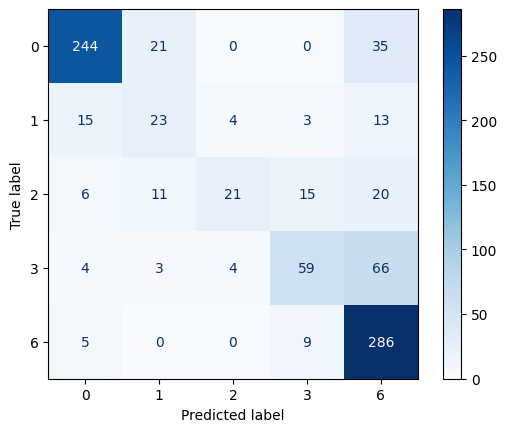

Report of Testing:
              precision    recall  f1-score   support

           0       0.89      0.81      0.85       300
           1       0.40      0.40      0.40        58
           2       0.72      0.29      0.41        73
           3       0.69      0.43      0.53       136
           6       0.68      0.95      0.79       300

    accuracy                           0.73       867
   macro avg       0.68      0.58      0.60       867
weighted avg       0.74      0.73      0.71       867

Train data is D1NAMO and test data is BigLab with threshold 70


/var/folders/t1/sgksm9r9385br4pts_lckj1w0000gn/T/ipykernel_1874/3598073534.py:131: RuntimeWarning: divide by zero encountered in scalar divide
  weight_for_4 = (1/class_occurences[4]) * (total/number_classes)
/var/folders/t1/sgksm9r9385br4pts_lckj1w0000gn/T/ipykernel_1874/3598073534.py:132: RuntimeWarning: divide by zero encountered in scalar divide
  weight_for_5= (1/class_occurences[5]) * (total/number_classes)


Epoch 1/500
 1/25 [>.............................] - ETA: 4s - loss: 1.3929 - sparse_categorical_accuracy: 0.2400
Epoch 1: val_loss improved from inf to 2.34109, saving model to CustomModel.weights.hdf5
25/25 [==============================] - 0s 4ms/step - loss: 1.2722 - sparse_categorical_accuracy: 0.5128 - val_loss: 2.3411 - val_sparse_categorical_accuracy: 0.3782 - lr: 0.0010
Epoch 2/500
 1/25 [>.............................] - ETA: 0s - loss: 1.0441 - sparse_categorical_accuracy: 0.6400
Epoch 2: val_loss improved from 2.34109 to 1.73501, saving model to CustomModel.weights.hdf5
25/25 [==============================] - 0s 2ms/step - loss: 1.1025 - sparse_categorical_accuracy: 0.5849 - val_loss: 1.7350 - val_sparse_categorical_accuracy: 0.3974 - lr: 0.0010
Epoch 3/500
 1/25 [>.............................] - ETA: 0s - loss: 1.0584 - sparse_categorical_accuracy: 0.7200
Epoch 3: val_loss improved from 1.73501 to 1.25433, saving model to CustomModel.weights.hdf5
25/25 [================

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - 0s 1ms/step - loss: 0.7646 - sparse_categorical_accuracy: 0.6651 - val_loss: 0.9188 - val_sparse_categorical_accuracy: 0.6346 - lr: 0.0010
Epoch 7/500
 1/25 [>.............................] - ETA: 0s - loss: 0.4873 - sparse_categorical_accuracy: 0.6000
Epoch 7: val_loss improved from 0.91884 to 0.82813, saving model to CustomModel.weights.hdf5
25/25 [==============================] - 0s 1ms/step - loss: 0.6808 - sparse_categorical_accuracy: 0.7083 - val_loss: 0.8281 - val_sparse_categorical_accuracy: 0.6538 - lr: 0.0010
Epoch 8/500
 1/25 [>.............................] - ETA: 0s - loss: 0.5861 - sparse_categorical_accuracy: 0.6000
Epoch 8: val_loss did not improve from 0.82813
25/25 [==============================] - 0s 1ms/step - loss: 0.7219 - sparse_categorical_accuracy: 0.6603 - val_loss: 0.8789 - val_sparse_categorical_accuracy: 0.6090 - lr: 0.0010
Epoch 9/500
 1/25 [>.............................] - ETA: 0s - loss: 0.6512 - sparse_categor

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 17: val_loss did not improve from 0.65449
25/25 [==============================] - 0s 1ms/step - loss: 0.5765 - sparse_categorical_accuracy: 0.7388 - val_loss: 0.6605 - val_sparse_categorical_accuracy: 0.7564 - lr: 4.0000e-05
Epoch 18/500
 1/25 [>.............................] - ETA: 0s - loss: 0.8196 - sparse_categorical_accuracy: 0.5600
Epoch 18: val_loss improved from 0.65449 to 0.64968, saving model to CustomModel.weights.hdf5
25/25 [==============================] - 0s 1ms/step - loss: 0.6002 - sparse_categorical_accuracy: 0.7099 - val_loss: 0.6497 - val_sparse_categorical_accuracy: 0.7628 - lr: 4.0000e-05
Epoch 19/500
 1/25 [>.............................] - ETA: 0s - loss: 0.3931 - sparse_categorical_accuracy: 0.9200
Epoch 19: val_loss improved from 0.64968 to 0.64962, saving model to CustomModel.weights.hdf5
25/25 [==============================] - 0s 1ms/step - loss: 0.5820 - sparse_categorical_accuracy: 0.7420 - val_loss: 0.6496 - val_sparse_categorical_accuracy: 0.756

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 15: val_loss improved from 0.52907 to 0.46448, saving model to CustomModel.weights.hdf5
25/25 [==============================] - 0s 1ms/step - loss: 0.6280 - sparse_categorical_accuracy: 0.6955 - val_loss: 0.4645 - val_sparse_categorical_accuracy: 0.8462 - lr: 0.0010
Epoch 16/500
 1/25 [>.............................] - ETA: 0s - loss: 0.4654 - sparse_categorical_accuracy: 0.6400
Epoch 16: val_loss did not improve from 0.46448
25/25 [==============================] - 0s 1ms/step - loss: 0.6258 - sparse_categorical_accuracy: 0.7099 - val_loss: 0.5360 - val_sparse_categorical_accuracy: 0.8077 - lr: 0.0010
Epoch 17/500
 1/25 [>.............................] - ETA: 0s - loss: 0.7603 - sparse_categorical_accuracy: 0.6400
Epoch 17: val_loss did not improve from 0.46448
25/25 [==============================] - 0s 1ms/step - loss: 0.6710 - sparse_categorical_accuracy: 0.6811 - val_loss: 0.5171 - val_sparse_categorical_accuracy: 0.8590 - lr: 0.0010
Epoch 18/500
 1/25 [>..................

Report of Training:
              precision    recall  f1-score   support

         0.0       0.92      0.92      0.92       300
         1.0       0.31      0.52      0.39        58
         2.0       0.53      0.52      0.52        73
         3.0       0.69      0.67      0.68       136
         6.0       0.94      0.83      0.88       300

    accuracy                           0.79       867
   macro avg       0.68      0.69      0.68       867
weighted avg       0.81      0.79      0.80       867

22/22 [==============================] - 0s 377us/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Report of Testing:
              precision    recall  f1-score   support

           0       0.80      0.96      0.87       200
           1       0.40      0.46      0.42        68
           2       0.65      0.46      0.54        81
           3       0.58      0.53      0.55       124
           6       0.88      0.81      0.84       200

    accuracy                           0.72       673
   macro avg       0.66      0.64      0.65       673
weighted avg       0.72      0.72      0.72       673



In [30]:
# Threshold 70 with sampling 300 for D1NAMO and 200 for BigLab and 5 classes

# The seed value needs to be called every time so that in every cell and order the model is reproduceable
# Seed value for reproducability according to https://stackoverflow.com/questions/32419510/how-to-get-reproducible-results-in-keras
seed_value=3
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.compat.v1.set_random_seed(seed_value)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

# define the dictionaries to undersample the data for each class, then call the undersampling function
dict_under = {0: 200, 1: 68 , 2: 81, 3: 124, 4: 0, 5: 0, 6: 200}
X_under_pre, y_under_pre = undersampling(X_pre, y_pre, dict_under)
dict_under_t1 = {0: 300, 1: 58, 2: 73, 3: 136, 4: 0, 5: 0, 6: 300}
X_under_t1, y_under_t1 = undersampling(X_t1, y_t1, dict_under_t1)

# call the function start_model to initialize the model and visualize the confusion matrices
print("Train data is BigLab and test data is D1NAMO with threshold 70")
start_model(X_under_pre, y_under_pre, X_under_t1, y_under_t1, "1DCNN_Trained_BigLab_70_300", "1DCNN_Tested_D1NAMO_70_300", batchsize=25, epoch= 500)
print("Train data is D1NAMO and test data is BigLab with threshold 70")
start_model(X_under_t1, y_under_t1, X_under_pre, y_under_pre, "1DCNN_Trained_D1NAMO_70_300", "1DCNN_Tested_BigLab_70_300", batchsize=25, epoch= 500)

Train data is BigLab and test data is D1NAMO with threshold 70
Epoch 1/500


/var/folders/t1/sgksm9r9385br4pts_lckj1w0000gn/T/ipykernel_1874/3598073534.py:131: RuntimeWarning: divide by zero encountered in scalar divide
  weight_for_4 = (1/class_occurences[4]) * (total/number_classes)
/var/folders/t1/sgksm9r9385br4pts_lckj1w0000gn/T/ipykernel_1874/3598073534.py:132: RuntimeWarning: divide by zero encountered in scalar divide
  weight_for_5= (1/class_occurences[5]) * (total/number_classes)


 1/21 [>.............................] - ETA: 4s - loss: 1.5438 - sparse_categorical_accuracy: 0.1250
Epoch 1: val_loss improved from inf to 2.60942, saving model to CustomModel.weights.hdf5
21/21 [==============================] - 0s 5ms/step - loss: 1.4263 - sparse_categorical_accuracy: 0.1641 - val_loss: 2.6094 - val_sparse_categorical_accuracy: 0.1605 - lr: 0.0010
Epoch 2/500
 1/21 [>.............................] - ETA: 0s - loss: 1.2611 - sparse_categorical_accuracy: 0.1875
Epoch 2: val_loss improved from 2.60942 to 2.59477, saving model to CustomModel.weights.hdf5
21/21 [==============================] - 0s 2ms/step - loss: 1.1416 - sparse_categorical_accuracy: 0.3715 - val_loss: 2.5948 - val_sparse_categorical_accuracy: 0.2593 - lr: 0.0010
Epoch 3/500
 1/21 [>.............................] - ETA: 0s - loss: 1.1273 - sparse_categorical_accuracy: 0.2500
Epoch 3: val_loss did not improve from 2.59477
21/21 [==============================] - 0s 1ms/step - loss: 1.0425 - sparse_cate

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 8: val_loss improved from 1.99911 to 1.72081, saving model to CustomModel.weights.hdf5
21/21 [==============================] - 0s 2ms/step - loss: 0.7746 - sparse_categorical_accuracy: 0.5820 - val_loss: 1.7208 - val_sparse_categorical_accuracy: 0.3827 - lr: 0.0010
Epoch 9/500
 1/21 [>.............................] - ETA: 0s - loss: 0.6763 - sparse_categorical_accuracy: 0.6250
Epoch 9: val_loss improved from 1.72081 to 1.39327, saving model to CustomModel.weights.hdf5
21/21 [==============================] - 0s 2ms/step - loss: 0.7764 - sparse_categorical_accuracy: 0.5604 - val_loss: 1.3933 - val_sparse_categorical_accuracy: 0.4074 - lr: 0.0010
Epoch 10/500
 1/21 [>.............................] - ETA: 0s - loss: 0.7657 - sparse_categorical_accuracy: 0.5000
Epoch 10: val_loss did not improve from 1.39327
21/21 [==============================] - 0s 1ms/step - loss: 0.7422 - sparse_categorical_accuracy: 0.5604 - val_loss: 1.6027 - val_sparse_categorical_accuracy: 0.4198 - lr: 0.0

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 22: val_loss did not improve from 0.65345

Epoch 22: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
21/21 [==============================] - 0s 1ms/step - loss: 0.5922 - sparse_categorical_accuracy: 0.6842 - val_loss: 0.6811 - val_sparse_categorical_accuracy: 0.7160 - lr: 0.0010
Epoch 23/500
 1/21 [>.............................] - ETA: 0s - loss: 0.4715 - sparse_categorical_accuracy: 0.7500
Epoch 23: val_loss did not improve from 0.65345
21/21 [==============================] - 0s 2ms/step - loss: 0.6430 - sparse_categorical_accuracy: 0.6068 - val_loss: 0.7238 - val_sparse_categorical_accuracy: 0.7160 - lr: 2.0000e-04
Epoch 24/500
 1/21 [>.............................] - ETA: 0s - loss: 0.4891 - sparse_categorical_accuracy: 0.6875
Epoch 24: val_loss did not improve from 0.65345
21/21 [==============================] - 0s 1ms/step - loss: 0.5937 - sparse_categorical_accuracy: 0.6533 - val_loss: 0.7509 - val_sparse_categorical_accuracy: 0.7037 - lr: 2.0000e-0

Report of Training:
              precision    recall  f1-score   support

         0.0       0.73      0.74      0.73       100
         1.0       0.45      0.66      0.53        68
         2.0       0.68      0.68      0.68        81
         3.0       0.75      0.49      0.59       100
         6.0       0.80      0.80      0.80       100

    accuracy                           0.67       449
   macro avg       0.68      0.67      0.67       449
weighted avg       0.70      0.67      0.68       449

14/14 [==============================] - 0s 453us/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


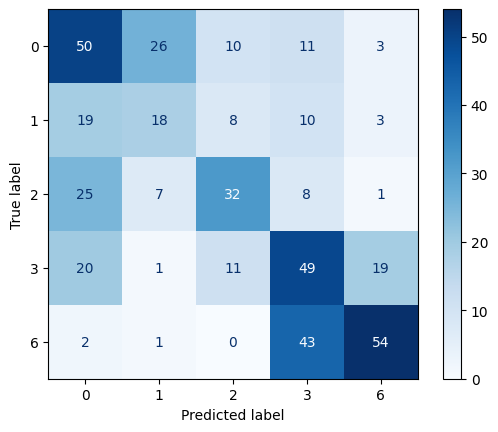

Report of Testing:
              precision    recall  f1-score   support

           0       0.43      0.50      0.46       100
           1       0.34      0.31      0.32        58
           2       0.52      0.44      0.48        73
           3       0.40      0.49      0.44       100
           6       0.68      0.54      0.60       100

    accuracy                           0.47       431
   macro avg       0.48      0.46      0.46       431
weighted avg       0.49      0.47      0.47       431

Train data is D1NAMO and test data is BigLab with threshold 70


/var/folders/t1/sgksm9r9385br4pts_lckj1w0000gn/T/ipykernel_1874/3598073534.py:131: RuntimeWarning: divide by zero encountered in scalar divide
  weight_for_4 = (1/class_occurences[4]) * (total/number_classes)
/var/folders/t1/sgksm9r9385br4pts_lckj1w0000gn/T/ipykernel_1874/3598073534.py:132: RuntimeWarning: divide by zero encountered in scalar divide
  weight_for_5= (1/class_occurences[5]) * (total/number_classes)


Epoch 1/500
 1/20 [>.............................] - ETA: 4s - loss: 1.7083 - sparse_categorical_accuracy: 0.2500
Epoch 1: val_loss improved from inf to 2.89992, saving model to CustomModel.weights.hdf5
20/20 [==============================] - 0s 5ms/step - loss: 1.3523 - sparse_categorical_accuracy: 0.2460 - val_loss: 2.8999 - val_sparse_categorical_accuracy: 0.3077 - lr: 0.0010
Epoch 2/500
 1/20 [>.............................] - ETA: 0s - loss: 1.2563 - sparse_categorical_accuracy: 0.2500
Epoch 2: val_loss improved from 2.89992 to 2.88962, saving model to CustomModel.weights.hdf5
20/20 [==============================] - 0s 2ms/step - loss: 1.1001 - sparse_categorical_accuracy: 0.4272 - val_loss: 2.8896 - val_sparse_categorical_accuracy: 0.3077 - lr: 0.0010
Epoch 3/500
 1/20 [>.............................] - ETA: 0s - loss: 0.9784 - sparse_categorical_accuracy: 0.4375
Epoch 3: val_loss improved from 2.88962 to 2.06814, saving model to CustomModel.weights.hdf5
20/20 [================

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


 1/20 [>.............................] - ETA: 0s - loss: 1.2780 - sparse_categorical_accuracy: 0.2500
Epoch 8: val_loss improved from 1.14230 to 1.09685, saving model to CustomModel.weights.hdf5
20/20 [==============================] - 0s 2ms/step - loss: 0.7860 - sparse_categorical_accuracy: 0.5922 - val_loss: 1.0969 - val_sparse_categorical_accuracy: 0.4872 - lr: 0.0010
Epoch 9/500
 1/20 [>.............................] - ETA: 0s - loss: 0.9033 - sparse_categorical_accuracy: 0.3750
Epoch 9: val_loss improved from 1.09685 to 1.01007, saving model to CustomModel.weights.hdf5
20/20 [==============================] - 0s 2ms/step - loss: 0.7792 - sparse_categorical_accuracy: 0.5825 - val_loss: 1.0101 - val_sparse_categorical_accuracy: 0.5256 - lr: 0.0010
Epoch 10/500
 1/20 [>.............................] - ETA: 0s - loss: 0.9755 - sparse_categorical_accuracy: 0.3750
Epoch 10: val_loss improved from 1.01007 to 1.00844, saving model to CustomModel.weights.hdf5
20/20 [======================

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


20/20 [==============================] - 0s 2ms/step - loss: 0.5907 - sparse_categorical_accuracy: 0.7097 - val_loss: 0.7295 - val_sparse_categorical_accuracy: 0.7051 - lr: 2.0000e-04
Epoch 24/500
 1/20 [>.............................] - ETA: 0s - loss: 0.3756 - sparse_categorical_accuracy: 0.9375
Epoch 24: val_loss improved from 0.72952 to 0.71256, saving model to CustomModel.weights.hdf5
20/20 [==============================] - 0s 2ms/step - loss: 0.5845 - sparse_categorical_accuracy: 0.6935 - val_loss: 0.7126 - val_sparse_categorical_accuracy: 0.6923 - lr: 2.0000e-04
Epoch 25/500
 1/20 [>.............................] - ETA: 0s - loss: 0.5605 - sparse_categorical_accuracy: 0.6875
Epoch 25: val_loss improved from 0.71256 to 0.70499, saving model to CustomModel.weights.hdf5
20/20 [==============================] - 0s 2ms/step - loss: 0.6444 - sparse_categorical_accuracy: 0.6484 - val_loss: 0.7050 - val_sparse_categorical_accuracy: 0.6923 - lr: 2.0000e-04
Epoch 26/500
 1/20 [>.........

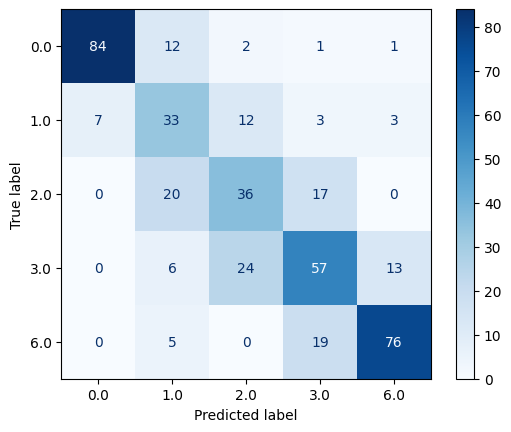

Report of Training:
              precision    recall  f1-score   support

         0.0       0.92      0.84      0.88       100
         1.0       0.43      0.57      0.49        58
         2.0       0.49      0.49      0.49        73
         3.0       0.59      0.57      0.58       100
         6.0       0.82      0.76      0.79       100

    accuracy                           0.66       431
   macro avg       0.65      0.65      0.65       431
weighted avg       0.68      0.66      0.67       431

15/15 [==============================] - 0s 415us/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Report of Testing:
              precision    recall  f1-score   support

           0       0.87      0.54      0.67       100
           1       0.45      0.57      0.50        68
           2       0.61      0.84      0.71        81
           3       0.54      0.72      0.62       100
           6       0.86      0.48      0.62       100

    accuracy                           0.63       449
   macro avg       0.67      0.63      0.62       449
weighted avg       0.68      0.63      0.63       449



In [43]:
# Threshold 70 with sampling 100 and 5 classes and seed number 44

# The seed value needs to be called every time so that in every cell and order the model is reproduceable
# Seed value for reproducability according to https://stackoverflow.com/questions/32419510/how-to-get-reproducible-results-in-keras
seed_value=44
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.compat.v1.set_random_seed(seed_value)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

# define the dictionaries to undersample the data for each class, then call the undersampling function
dict_under = {0: 100, 1: 68 , 2: 81, 3: 100, 4: 0, 5: 0, 6: 100}
X_under_pre, y_under_pre = undersampling(X_pre, y_pre, dict_under)
dict_under_t1 = {0: 100, 1: 58, 2: 73, 3: 100, 4: 0, 5: 0, 6: 100}
X_under_t1, y_under_t1 = undersampling(X_t1, y_t1, dict_under_t1)

# call the function start_model to initialize the model and visualize the confusion matrices
print("Train data is BigLab and test data is D1NAMO with threshold 70")
start_model(X_under_pre, y_under_pre, X_under_t1, y_under_t1, "1DCNN_Trained_BigLab_70_seed44", "1DCNN_Tested_D1NAMO_70_seed44", batchsize=16, epoch= 500)
print("Train data is D1NAMO and test data is BigLab with threshold 70")
start_model(X_under_t1, y_under_t1, X_under_pre, y_under_pre, "1DCNN_Trained_D1NAMO_70_seed44", "1DCNN_Tested_BigLab_70_seed44", batchsize=16, epoch= 500)


## Threshold 75

In [31]:
# define the paths and call the load data function to have a time series representation of the data
path_pre = '/Users/beyzacinar/Desktop/HYPO/CODE_Notebook_new/data_thresholds_bereinigt/thresh75'
X_pre, y_pre = load_data(path_pre)
path_t1 = '/Users/beyzacinar/Desktop/TSC_Hypoglycemia/Stacked_Daten/bereinigtStacked/d1namo'
X_t1, y_t1 = load_data(path_t1)

Train data is BigLab and test data is D1NAMO with threshold 75
Epoch 1/500


/var/folders/t1/sgksm9r9385br4pts_lckj1w0000gn/T/ipykernel_1874/3598073534.py:131: RuntimeWarning: divide by zero encountered in scalar divide
  weight_for_4 = (1/class_occurences[4]) * (total/number_classes)
/var/folders/t1/sgksm9r9385br4pts_lckj1w0000gn/T/ipykernel_1874/3598073534.py:132: RuntimeWarning: divide by zero encountered in scalar divide
  weight_for_5= (1/class_occurences[5]) * (total/number_classes)


 1/19 [>.............................] - ETA: 3s - loss: 1.5467 - sparse_categorical_accuracy: 0.0938
Epoch 1: val_loss improved from inf to 3.34846, saving model to CustomModel.weights.hdf5
19/19 [==============================] - 0s 6ms/step - loss: 1.2446 - sparse_categorical_accuracy: 0.3217 - val_loss: 3.3485 - val_sparse_categorical_accuracy: 0.2600 - lr: 0.0010
Epoch 2/500
 1/19 [>.............................] - ETA: 0s - loss: 1.1882 - sparse_categorical_accuracy: 0.4062
Epoch 2: val_loss did not improve from 3.34846
19/19 [==============================] - 0s 1ms/step - loss: 0.9998 - sparse_categorical_accuracy: 0.4983 - val_loss: 3.4719 - val_sparse_categorical_accuracy: 0.3133 - lr: 0.0010
Epoch 3/500
 1/19 [>.............................] - ETA: 0s - loss: 1.0056 - sparse_categorical_accuracy: 0.5312
Epoch 3: val_loss did not improve from 3.34846
19/19 [==============================] - 0s 1ms/step - loss: 0.8682 - sparse_categorical_accuracy: 0.5133 - val_loss: 3.6078 - 

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 8: val_loss improved from 2.03026 to 1.67204, saving model to CustomModel.weights.hdf5
19/19 [==============================] - 0s 2ms/step - loss: 0.6807 - sparse_categorical_accuracy: 0.6183 - val_loss: 1.6720 - val_sparse_categorical_accuracy: 0.3600 - lr: 0.0010
Epoch 9/500
 1/19 [>.............................] - ETA: 0s - loss: 0.4952 - sparse_categorical_accuracy: 0.5625
Epoch 9: val_loss improved from 1.67204 to 1.38253, saving model to CustomModel.weights.hdf5
19/19 [==============================] - 0s 2ms/step - loss: 0.6587 - sparse_categorical_accuracy: 0.6217 - val_loss: 1.3825 - val_sparse_categorical_accuracy: 0.4533 - lr: 0.0010
Epoch 10/500
 1/19 [>.............................] - ETA: 0s - loss: 0.5777 - sparse_categorical_accuracy: 0.7500
Epoch 10: val_loss improved from 1.38253 to 1.12971, saving model to CustomModel.weights.hdf5
19/19 [==============================] - 0s 2ms/step - loss: 0.6212 - sparse_categorical_accuracy: 0.6583 - val_loss: 1.1297 - val

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 37: val_loss improved from 0.59294 to 0.58749, saving model to CustomModel.weights.hdf5
19/19 [==============================] - 0s 2ms/step - loss: 0.5468 - sparse_categorical_accuracy: 0.6883 - val_loss: 0.5875 - val_sparse_categorical_accuracy: 0.7533 - lr: 2.0000e-04
Epoch 38/500
 1/19 [>.............................] - ETA: 0s - loss: 0.6343 - sparse_categorical_accuracy: 0.6250
Epoch 38: val_loss improved from 0.58749 to 0.57688, saving model to CustomModel.weights.hdf5
19/19 [==============================] - 0s 2ms/step - loss: 0.5050 - sparse_categorical_accuracy: 0.6767 - val_loss: 0.5769 - val_sparse_categorical_accuracy: 0.7800 - lr: 2.0000e-04
Epoch 39/500
 1/19 [>.............................] - ETA: 0s - loss: 0.4651 - sparse_categorical_accuracy: 0.7188
Epoch 39: val_loss improved from 0.57688 to 0.56547, saving model to CustomModel.weights.hdf5
19/19 [==============================] - 0s 1ms/step - loss: 0.5360 - sparse_categorical_accuracy: 0.6783 - val_loss: 0

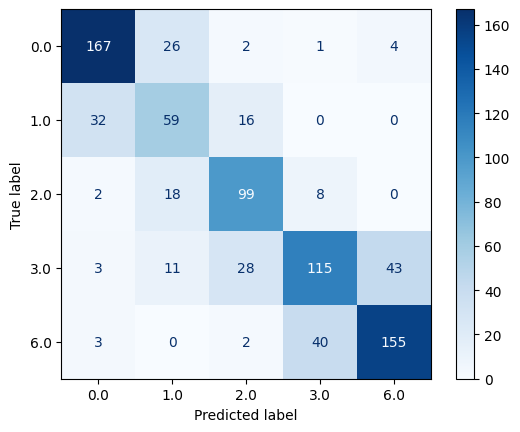

Report of Training:
              precision    recall  f1-score   support

         0.0       0.81      0.83      0.82       200
         1.0       0.52      0.55      0.53       107
         2.0       0.67      0.78      0.72       127
         3.0       0.70      0.57      0.63       200
         6.0       0.77      0.78      0.77       200

    accuracy                           0.71       834
   macro avg       0.69      0.70      0.70       834
weighted avg       0.71      0.71      0.71       834

14/14 [==============================] - 0s 406us/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Report of Testing:
              precision    recall  f1-score   support

           0       0.82      0.49      0.61       100
           1       0.34      0.43      0.38        58
           2       0.36      0.60      0.45        73
           3       0.41      0.42      0.42       100
           6       0.77      0.57      0.66       100

    accuracy                           0.50       431
   macro avg       0.54      0.50      0.50       431
weighted avg       0.57      0.50      0.52       431

Train data is D1NAMO and test data is BigLab with threshold 75
27/27 [==============================] - 0s 373us/step


Report of Testing:
              precision    recall  f1-score   support

           0       0.84      0.59      0.69       200
           1       0.32      0.45      0.38       107
           2       0.54      0.45      0.49       127
           3       0.50      0.75      0.60       200
           6       0.84      0.58      0.69       200

    accuracy                           0.59       834
   macro avg       0.61      0.56      0.57       834
weighted avg       0.65      0.59      0.60       834



In [32]:
# Threshold 75 with sampling 200 and 5 classes

# The seed value needs to be called every time so that in every cell and order the model is reproduceable
# Seed value for reproducability according to https://stackoverflow.com/questions/32419510/how-to-get-reproducible-results-in-keras
seed_value=3
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.compat.v1.set_random_seed(seed_value)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

# define the dictionaries to undersample the data for each class, then call the undersampling function
dict_under = {0: 200, 1: 107, 2: 127, 3: 200, 4: 0, 5: 0, 6: 200}
X_under_pre, y_under_pre = undersampling(X_pre, y_pre, dict_under)
dict_under_t1 = {0: 100, 1: 58, 2: 73, 3: 100, 4: 0, 5: 0, 6: 100}
X_under_t1, y_under_t1 = undersampling(X_t1, y_t1, dict_under_t1)

# call the function start_model to initialize the model and visualize the confusion matrices
print("Train data is BigLab and test data is D1NAMO with threshold 75")
start_model(X_under_pre, y_under_pre, X_under_t1, y_under_t1, "1DCNN_Trained_BigLab_75_200", "1DCNN_Tested_D1NAMO_75_200", batchsize=32, epoch= 500)
print("Train data is D1NAMO and test data is BigLab with threshold 75")
# Load trained D1NAMO model and test the BigLab data with 75 threshold
Testing_from_D1NAMO("Models/1DCNN_Trained_D1NAMO_70.hdf5", X_under_pre, y_under_pre, "Confusion_Matrices/1DCNN_Tested_BigLab_75_200.png")

Train data is BigLab and test data is D1NAMO with threshold 75
Epoch 1/500


/var/folders/t1/sgksm9r9385br4pts_lckj1w0000gn/T/ipykernel_1874/3598073534.py:131: RuntimeWarning: divide by zero encountered in scalar divide
  weight_for_4 = (1/class_occurences[4]) * (total/number_classes)
/var/folders/t1/sgksm9r9385br4pts_lckj1w0000gn/T/ipykernel_1874/3598073534.py:132: RuntimeWarning: divide by zero encountered in scalar divide
  weight_for_5= (1/class_occurences[5]) * (total/number_classes)


 1/23 [>.............................] - ETA: 4s - loss: 1.3984 - sparse_categorical_accuracy: 0.3750
Epoch 1: val_loss improved from inf to 5.50831, saving model to CustomModel.weights.hdf5
23/23 [==============================] - 0s 4ms/step - loss: 1.2629 - sparse_categorical_accuracy: 0.3028 - val_loss: 5.5083 - val_sparse_categorical_accuracy: 0.1556 - lr: 0.0010
Epoch 2/500
 1/23 [>.............................] - ETA: 0s - loss: 1.1773 - sparse_categorical_accuracy: 0.3125
Epoch 2: val_loss did not improve from 5.50831
23/23 [==============================] - 0s 1ms/step - loss: 1.0159 - sparse_categorical_accuracy: 0.4194 - val_loss: 5.9894 - val_sparse_categorical_accuracy: 0.1889 - lr: 0.0010
Epoch 3/500
 1/23 [>.............................] - ETA: 0s - loss: 1.1152 - sparse_categorical_accuracy: 0.1875
Epoch 3: val_loss improved from 5.50831 to 4.87838, saving model to CustomModel.weights.hdf5
23/23 [==============================] - 0s 1ms/step - loss: 0.9501 - sparse_cate

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 8: val_loss improved from 2.51948 to 1.84688, saving model to CustomModel.weights.hdf5
23/23 [==============================] - 0s 1ms/step - loss: 0.6896 - sparse_categorical_accuracy: 0.5861 - val_loss: 1.8469 - val_sparse_categorical_accuracy: 0.2444 - lr: 0.0010
Epoch 9/500
 1/23 [>.............................] - ETA: 0s - loss: 0.6523 - sparse_categorical_accuracy: 0.6875
Epoch 9: val_loss improved from 1.84688 to 1.36983, saving model to CustomModel.weights.hdf5
23/23 [==============================] - 0s 1ms/step - loss: 0.6814 - sparse_categorical_accuracy: 0.5833 - val_loss: 1.3698 - val_sparse_categorical_accuracy: 0.3889 - lr: 0.0010
Epoch 10/500
 1/23 [>.............................] - ETA: 0s - loss: 0.6775 - sparse_categorical_accuracy: 0.7500
Epoch 10: val_loss did not improve from 1.36983
23/23 [==============================] - 0s 981us/step - loss: 0.6641 - sparse_categorical_accuracy: 0.6278 - val_loss: 1.3793 - val_sparse_categorical_accuracy: 0.4444 - lr: 0

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 33: val_loss improved from 0.70780 to 0.69972, saving model to CustomModel.weights.hdf5
23/23 [==============================] - 0s 1ms/step - loss: 0.5823 - sparse_categorical_accuracy: 0.6472 - val_loss: 0.6997 - val_sparse_categorical_accuracy: 0.7111 - lr: 4.0000e-05
Epoch 34/500
 1/23 [>.............................] - ETA: 0s - loss: 0.6189 - sparse_categorical_accuracy: 0.4375
Epoch 34: val_loss did not improve from 0.69972
23/23 [==============================] - 0s 994us/step - loss: 0.5454 - sparse_categorical_accuracy: 0.6750 - val_loss: 0.7012 - val_sparse_categorical_accuracy: 0.7111 - lr: 4.0000e-05
Epoch 35/500
 1/23 [>.............................] - ETA: 0s - loss: 0.7759 - sparse_categorical_accuracy: 0.5625
Epoch 35: val_loss improved from 0.69972 to 0.69926, saving model to CustomModel.weights.hdf5
23/23 [==============================] - 0s 1ms/step - loss: 0.5568 - sparse_categorical_accuracy: 0.6750 - val_loss: 0.6993 - val_sparse_categorical_accuracy: 0.7

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 29: val_loss did not improve from 0.68688
23/23 [==============================] - 0s 997us/step - loss: 0.6149 - sparse_categorical_accuracy: 0.6333 - val_loss: 0.6998 - val_sparse_categorical_accuracy: 0.6889 - lr: 4.0000e-05
Epoch 30/500
 1/23 [>.............................] - ETA: 0s - loss: 0.4338 - sparse_categorical_accuracy: 0.9375
Epoch 30: val_loss did not improve from 0.68688

Epoch 30: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.
23/23 [==============================] - 0s 1ms/step - loss: 0.5804 - sparse_categorical_accuracy: 0.6583 - val_loss: 0.6951 - val_sparse_categorical_accuracy: 0.6556 - lr: 4.0000e-05
Epoch 31/500
 1/23 [>.............................] - ETA: 0s - loss: 0.4956 - sparse_categorical_accuracy: 0.8125
Epoch 31: val_loss did not improve from 0.68688
23/23 [==============================] - 0s 975us/step - loss: 0.5911 - sparse_categorical_accuracy: 0.6417 - val_loss: 0.6919 - val_sparse_categorical_accuracy: 0.6556 - lr: 8.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 35: val_loss did not improve from 0.65603

Epoch 35: ReduceLROnPlateau reducing learning rate to 1.6000001778593287e-06.
23/23 [==============================] - 0s 1000us/step - loss: 0.5777 - sparse_categorical_accuracy: 0.6861 - val_loss: 0.6611 - val_sparse_categorical_accuracy: 0.7222 - lr: 8.0000e-06
Epoch 36/500
 1/23 [>.............................] - ETA: 0s - loss: 0.5396 - sparse_categorical_accuracy: 0.8125
Epoch 36: val_loss did not improve from 0.65603
23/23 [==============================] - 0s 1ms/step - loss: 0.5503 - sparse_categorical_accuracy: 0.6694 - val_loss: 0.6605 - val_sparse_categorical_accuracy: 0.7222 - lr: 1.6000e-06
Epoch 37/500
 1/23 [>.............................] - ETA: 0s - loss: 0.4453 - sparse_categorical_accuracy: 0.6875
Epoch 37: val_loss did not improve from 0.65603
23/23 [==============================] - 0s 1ms/step - loss: 0.5511 - sparse_categorical_accuracy: 0.6944 - val_loss: 0.6612 - val_sparse_categorical_accuracy: 0.7222 - lr: 1.

Report of Training:
              precision    recall  f1-score   support

         0.0       0.66      0.85      0.75       100
         1.0       0.60      0.54      0.57       100
         2.0       0.73      0.74      0.73       100
         3.0       0.68      0.52      0.59       100
         6.0       0.75      0.77      0.76       100

    accuracy                           0.68       500
   macro avg       0.68      0.68      0.68       500
weighted avg       0.68      0.68      0.68       500

14/14 [==============================] - 0s 407us/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


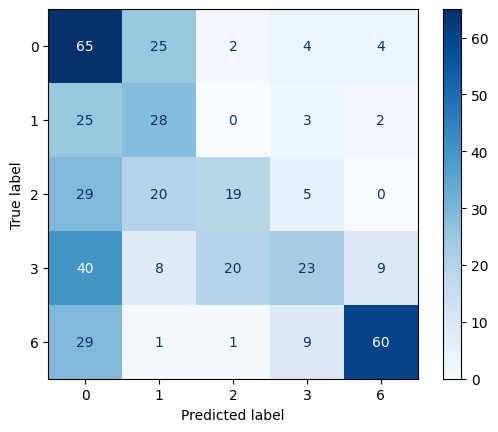

Report of Testing:
              precision    recall  f1-score   support

           0       0.35      0.65      0.45       100
           1       0.34      0.48      0.40        58
           2       0.45      0.26      0.33        73
           3       0.52      0.23      0.32       100
           6       0.80      0.60      0.69       100

    accuracy                           0.45       431
   macro avg       0.49      0.44      0.44       431
weighted avg       0.51      0.45      0.45       431

Train data is D1NAMO and test data is BigLab with threshold 75
16/16 [==============================] - 0s 395us/step


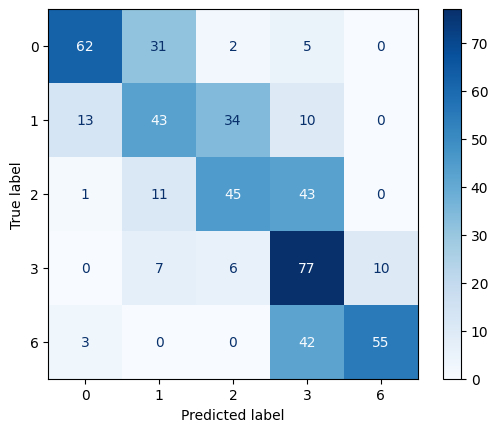

Report of Testing:
              precision    recall  f1-score   support

           0       0.78      0.62      0.69       100
           1       0.47      0.43      0.45       100
           2       0.52      0.45      0.48       100
           3       0.44      0.77      0.56       100
           6       0.85      0.55      0.67       100

    accuracy                           0.56       500
   macro avg       0.61      0.56      0.57       500
weighted avg       0.61      0.56      0.57       500



In [33]:
# Threshold 75 with sampling 100 and 5 classes

# The seed value needs to be called every time so that in every cell and order the model is reproduceable
# Seed value for reproducability according to https://stackoverflow.com/questions/32419510/how-to-get-reproducible-results-in-keras
seed_value=3
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.compat.v1.set_random_seed(seed_value)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

# define the dictionaries to undersample the data for each class, then call the undersampling function
dict_under = {0: 100, 1: 100, 2: 100, 3: 100, 4: 0, 5: 0, 6: 100}
X_under_pre, y_under_pre = undersampling(X_pre, y_pre, dict_under)
dict_under_t1 = {0: 100, 1: 58, 2: 73, 3: 100, 4: 0, 5: 0, 6: 100}
X_under_t1, y_under_t1 = undersampling(X_t1, y_t1, dict_under_t1)

# call the function start_model to initialize the model and visualize the confusion matrices
print("Train data is BigLab and test data is D1NAMO with threshold 75")
start_model(X_under_pre, y_under_pre, X_under_t1, y_under_t1, "1DCNN_Trained_BigLab_75_100", "1DCNN_Tested_D1NAMO_75_100", batchsize=16, epoch= 500)
print("Train data is D1NAMO and test data is BigLab with threshold 75")
# Load trained D1NAMO model and test the BigLab data with 75 threshold
Testing_from_D1NAMO("Models/1DCNN_Trained_D1NAMO_70.hdf5", X_under_pre, y_under_pre, "Confusion_Matrices/1DCNN_Tested_BigLab_75_100.png")

## Threshold 80

In [34]:
# define the paths and call the load data function to have a time series representation of the data
path_pre = '/Users/beyzacinar/Desktop/HYPO/CODE_Notebook_new/data_thresholds_bereinigt/thresh80'
X_pre, y_pre = load_data(path_pre)     
path_t1 = '/Users/beyzacinar/Desktop/TSC_Hypoglycemia/Stacked_Daten/bereinigtStacked/d1namo'
X_t1, y_t1 = load_data(path_t1)

In [35]:
# Threshold 80 with sampling 400 and 5 classes

# The seed value needs to be called every time so that in every cell and order the model is reproduceable
# Seed value for reproducability according to https://stackoverflow.com/questions/32419510/how-to-get-reproducible-results-in-keras
seed_value=3
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.compat.v1.set_random_seed(seed_value)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

# define the dictionaries to undersample the data for each class, then call the undersampling function
dict_under = {0: 400, 1: 186, 2: 224, 3: 382, 4: 0, 5: 0, 6: 400}
X_under_pre, y_under_pre = undersampling(X_pre, y_pre, dict_under)
dict_under_t1 = {0: 100, 1: 58, 2: 73, 3: 100, 4: 0, 5: 0, 6: 100}
X_under_t1, y_under_t1 = undersampling(X_t1, y_t1, dict_under_t1)

# call the function start_model to initialize the model and visualize the confusion matrices
print("Train data is BigLab and test data is D1NAMO with threshold 80")
start_model(X_under_pre, y_under_pre, X_under_t1, y_under_t1, "1DCNN_Trained_BigLab_80_400", "1DCNN_Tested_D1NAMO_80_400", batchsize=40, epoch= 500)
print("Train data is D1NAMO and test data is BigLab with threshold 80")
# Load trained D1NAMO model and test the BigLab data with 80 threshold
Testing_from_D1NAMO("Models/1DCNN_Trained_D1NAMO_70.hdf5", X_under_pre, y_under_pre, "Confusion_Matrices/1DCNN_Tested_BigLab_80_400.png" )

Train data is BigLab and test data is D1NAMO with threshold 80
Epoch 1/500


/var/folders/t1/sgksm9r9385br4pts_lckj1w0000gn/T/ipykernel_1874/3598073534.py:131: RuntimeWarning: divide by zero encountered in scalar divide
  weight_for_4 = (1/class_occurences[4]) * (total/number_classes)
/var/folders/t1/sgksm9r9385br4pts_lckj1w0000gn/T/ipykernel_1874/3598073534.py:132: RuntimeWarning: divide by zero encountered in scalar divide
  weight_for_5= (1/class_occurences[5]) * (total/number_classes)


 1/29 [>.............................] - ETA: 6s - loss: 1.5494 - sparse_categorical_accuracy: 0.0750
Epoch 1: val_loss improved from inf to 6.46363, saving model to CustomModel.weights.hdf5
29/29 [==============================] - 0s 4ms/step - loss: 1.2020 - sparse_categorical_accuracy: 0.3773 - val_loss: 6.4636 - val_sparse_categorical_accuracy: 0.2578 - lr: 0.0010
Epoch 2/500
 1/29 [>.............................] - ETA: 0s - loss: 0.9399 - sparse_categorical_accuracy: 0.6000
Epoch 2: val_loss improved from 6.46363 to 5.03622, saving model to CustomModel.weights.hdf5
29/29 [==============================] - 0s 2ms/step - loss: 0.8977 - sparse_categorical_accuracy: 0.5397 - val_loss: 5.0362 - val_sparse_categorical_accuracy: 0.2544 - lr: 0.0010
Epoch 3/500
 1/29 [>.............................] - ETA: 0s - loss: 0.8235 - sparse_categorical_accuracy: 0.5750
Epoch 3: val_loss improved from 5.03622 to 3.83399, saving model to CustomModel.weights.hdf5
29/29 [============================

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 6: val_loss improved from 2.04471 to 1.87648, saving model to CustomModel.weights.hdf5
29/29 [==============================] - 0s 1ms/step - loss: 0.6086 - sparse_categorical_accuracy: 0.6603 - val_loss: 1.8765 - val_sparse_categorical_accuracy: 0.3206 - lr: 0.0010
Epoch 7/500
 1/29 [>.............................] - ETA: 0s - loss: 0.3977 - sparse_categorical_accuracy: 0.9000
Epoch 7: val_loss improved from 1.87648 to 1.42823, saving model to CustomModel.weights.hdf5
29/29 [==============================] - 0s 1ms/step - loss: 0.5975 - sparse_categorical_accuracy: 0.6716 - val_loss: 1.4282 - val_sparse_categorical_accuracy: 0.4390 - lr: 0.0010
Epoch 8/500
 1/29 [>.............................] - ETA: 0s - loss: 0.5661 - sparse_categorical_accuracy: 0.6000
Epoch 8: val_loss did not improve from 1.42823
29/29 [==============================] - 0s 1ms/step - loss: 0.6049 - sparse_categorical_accuracy: 0.6760 - val_loss: 1.4857 - val_sparse_categorical_accuracy: 0.4634 - lr: 0.001

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 29: val_loss did not improve from 0.55398
29/29 [==============================] - 0s 1ms/step - loss: 0.4940 - sparse_categorical_accuracy: 0.7074 - val_loss: 0.5646 - val_sparse_categorical_accuracy: 0.7805 - lr: 8.0000e-06
Epoch 30/500
 1/29 [>.............................] - ETA: 0s - loss: 0.5575 - sparse_categorical_accuracy: 0.6000
Epoch 30: val_loss did not improve from 0.55398
29/29 [==============================] - 0s 1ms/step - loss: 0.5012 - sparse_categorical_accuracy: 0.7057 - val_loss: 0.5606 - val_sparse_categorical_accuracy: 0.7875 - lr: 8.0000e-06
Epoch 31/500
 1/29 [>.............................] - ETA: 0s - loss: 0.4556 - sparse_categorical_accuracy: 0.8000
Epoch 31: val_loss did not improve from 0.55398

Epoch 31: ReduceLROnPlateau reducing learning rate to 1.6000001778593287e-06.
29/29 [==============================] - 0s 1ms/step - loss: 0.5032 - sparse_categorical_accuracy: 0.7127 - val_loss: 0.5582 - val_sparse_categorical_accuracy: 0.7909 - lr: 8.000

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 32: val_loss improved from 0.51848 to 0.51840, saving model to CustomModel.weights.hdf5
29/29 [==============================] - 0s 1ms/step - loss: 0.5047 - sparse_categorical_accuracy: 0.7155 - val_loss: 0.5184 - val_sparse_categorical_accuracy: 0.7909 - lr: 4.0000e-05
Epoch 33/500
 1/29 [>.............................] - ETA: 0s - loss: 0.4456 - sparse_categorical_accuracy: 0.6750
Epoch 33: val_loss improved from 0.51840 to 0.51709, saving model to CustomModel.weights.hdf5
29/29 [==============================] - 0s 1ms/step - loss: 0.5022 - sparse_categorical_accuracy: 0.7068 - val_loss: 0.5171 - val_sparse_categorical_accuracy: 0.7944 - lr: 4.0000e-05
Epoch 34/500
 1/29 [>.............................] - ETA: 0s - loss: 0.6252 - sparse_categorical_accuracy: 0.7250
Epoch 34: val_loss improved from 0.51709 to 0.51658, saving model to CustomModel.weights.hdf5
29/29 [==============================] - 0s 1ms/step - loss: 0.5094 - sparse_categorical_accuracy: 0.7068 - val_loss: 0

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 23: val_loss did not improve from 0.51617

Epoch 23: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.
29/29 [==============================] - 0s 1ms/step - loss: 0.5013 - sparse_categorical_accuracy: 0.7129 - val_loss: 0.5419 - val_sparse_categorical_accuracy: 0.7561 - lr: 4.0000e-05
Epoch 24/500
 1/29 [>.............................] - ETA: 0s - loss: 0.5004 - sparse_categorical_accuracy: 0.7000
Epoch 24: val_loss did not improve from 0.51617
29/29 [==============================] - 0s 1ms/step - loss: 0.5017 - sparse_categorical_accuracy: 0.7243 - val_loss: 0.5435 - val_sparse_categorical_accuracy: 0.7596 - lr: 8.0000e-06
Epoch 25/500
 1/29 [>.............................] - ETA: 0s - loss: 0.4867 - sparse_categorical_accuracy: 0.6500
Epoch 25: val_loss did not improve from 0.51617
29/29 [==============================] - 0s 1ms/step - loss: 0.5017 - sparse_categorical_accuracy: 0.7059 - val_loss: 0.5412 - val_sparse_categorical_accuracy: 0.7526 - lr: 8.0000

Report of Training:
              precision    recall  f1-score   support

         0.0       0.85      0.89      0.87       400
         1.0       0.61      0.60      0.61       186
         2.0       0.72      0.76      0.74       224
         3.0       0.74      0.68      0.71       382
         6.0       0.82      0.82      0.82       400

    accuracy                           0.77      1592
   macro avg       0.75      0.75      0.75      1592
weighted avg       0.77      0.77      0.77      1592

14/14 [==============================] - 0s 379us/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Report of Testing:
              precision    recall  f1-score   support

           0       0.41      0.67      0.51       100
           1       0.22      0.28      0.24        58
           2       0.59      0.22      0.32        73
           3       0.49      0.44      0.47       100
           6       0.91      0.71      0.80       100

    accuracy                           0.50       431
   macro avg       0.52      0.46      0.47       431
weighted avg       0.55      0.50      0.50       431

Train data is D1NAMO and test data is BigLab with threshold 80
50/50 [==============================] - 0s 334us/step


Report of Testing:
              precision    recall  f1-score   support

           0       0.87      0.45      0.60       400
           1       0.23      0.22      0.22       186
           2       0.45      0.25      0.32       224
           3       0.42      0.84      0.56       382
           6       0.78      0.64      0.70       400

    accuracy                           0.54      1592
   macro avg       0.55      0.48      0.48      1592
weighted avg       0.61      0.54      0.53      1592



Train data is BigLab and test data is D1NAMO with threshold 80
Epoch 1/500


/var/folders/t1/sgksm9r9385br4pts_lckj1w0000gn/T/ipykernel_1874/3598073534.py:131: RuntimeWarning: divide by zero encountered in scalar divide
  weight_for_4 = (1/class_occurences[4]) * (total/number_classes)
/var/folders/t1/sgksm9r9385br4pts_lckj1w0000gn/T/ipykernel_1874/3598073534.py:132: RuntimeWarning: divide by zero encountered in scalar divide
  weight_for_5= (1/class_occurences[5]) * (total/number_classes)


 1/32 [..............................] - ETA: 6s - loss: 1.6802 - sparse_categorical_accuracy: 0.1400
Epoch 1: val_loss improved from inf to 4.13769, saving model to CustomModel.weights.hdf5
32/32 [==============================] - 0s 8ms/step - loss: 1.1882 - sparse_categorical_accuracy: 0.4623 - val_loss: 4.1377 - val_sparse_categorical_accuracy: 0.3316 - lr: 0.0010
Epoch 2/500
 1/32 [..............................] - ETA: 0s - loss: 1.1078 - sparse_categorical_accuracy: 0.5000
Epoch 2: val_loss improved from 4.13769 to 3.69264, saving model to CustomModel.weights.hdf5
32/32 [==============================] - 0s 1ms/step - loss: 0.8982 - sparse_categorical_accuracy: 0.5529 - val_loss: 3.6926 - val_sparse_categorical_accuracy: 0.3392 - lr: 0.0010
Epoch 3/500
 1/32 [..............................] - ETA: 0s - loss: 0.7886 - sparse_categorical_accuracy: 0.5600
Epoch 3: val_loss improved from 3.69264 to 2.99404, saving model to CustomModel.weights.hdf5
32/32 [============================

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 6: val_loss improved from 2.30631 to 2.06854, saving model to CustomModel.weights.hdf5
32/32 [==============================] - 0s 1ms/step - loss: 0.6240 - sparse_categorical_accuracy: 0.6715 - val_loss: 2.0685 - val_sparse_categorical_accuracy: 0.3772 - lr: 0.0010
Epoch 7/500
 1/32 [..............................] - ETA: 0s - loss: 0.5252 - sparse_categorical_accuracy: 0.6800
Epoch 7: val_loss improved from 2.06854 to 1.95768, saving model to CustomModel.weights.hdf5
32/32 [==============================] - 0s 2ms/step - loss: 0.6090 - sparse_categorical_accuracy: 0.6918 - val_loss: 1.9577 - val_sparse_categorical_accuracy: 0.4354 - lr: 0.0010
Epoch 8/500
 1/32 [..............................] - ETA: 0s - loss: 0.6708 - sparse_categorical_accuracy: 0.6400
Epoch 8: val_loss improved from 1.95768 to 1.30092, saving model to CustomModel.weights.hdf5
32/32 [==============================] - 0s 1ms/step - loss: 0.5891 - sparse_categorical_accuracy: 0.6798 - val_loss: 1.3009 - val_s

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 23: val_loss did not improve from 0.51669
32/32 [==============================] - 0s 1ms/step - loss: 0.4964 - sparse_categorical_accuracy: 0.7349 - val_loss: 0.5429 - val_sparse_categorical_accuracy: 0.8025 - lr: 4.0000e-05
Epoch 24/500
 1/32 [..............................] - ETA: 0s - loss: 0.5083 - sparse_categorical_accuracy: 0.6400
Epoch 24: val_loss did not improve from 0.51669
32/32 [==============================] - 0s 1ms/step - loss: 0.5321 - sparse_categorical_accuracy: 0.7127 - val_loss: 0.5355 - val_sparse_categorical_accuracy: 0.7975 - lr: 4.0000e-05
Epoch 25/500
 1/32 [..............................] - ETA: 0s - loss: 0.4712 - sparse_categorical_accuracy: 0.8200
Epoch 25: val_loss did not improve from 0.51669

Epoch 25: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.
32/32 [==============================] - 0s 1ms/step - loss: 0.4907 - sparse_categorical_accuracy: 0.7362 - val_loss: 0.5348 - val_sparse_categorical_accuracy: 0.7975 - lr: 4.0000

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 23: val_loss did not improve from 0.51630

Epoch 23: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.
32/32 [==============================] - 0s 1ms/step - loss: 0.4767 - sparse_categorical_accuracy: 0.7433 - val_loss: 0.5427 - val_sparse_categorical_accuracy: 0.7899 - lr: 4.0000e-05
Epoch 24/500
 1/32 [..............................] - ETA: 0s - loss: 0.5929 - sparse_categorical_accuracy: 0.7000
Epoch 24: val_loss did not improve from 0.51630
32/32 [==============================] - 0s 1ms/step - loss: 0.4998 - sparse_categorical_accuracy: 0.7351 - val_loss: 0.5308 - val_sparse_categorical_accuracy: 0.8000 - lr: 8.0000e-06
Epoch 25/500
 1/32 [..............................] - ETA: 0s - loss: 0.4885 - sparse_categorical_accuracy: 0.6800
Epoch 25: val_loss did not improve from 0.51630
32/32 [==============================] - 0s 1ms/step - loss: 0.4967 - sparse_categorical_accuracy: 0.7376 - val_loss: 0.5246 - val_sparse_categorical_accuracy: 0.8025 - lr: 8.0000

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 27: val_loss did not improve from 0.50513

Epoch 27: ReduceLROnPlateau reducing learning rate to 1.6000001778593287e-06.
32/32 [==============================] - 0s 1ms/step - loss: 0.4909 - sparse_categorical_accuracy: 0.7262 - val_loss: 0.5079 - val_sparse_categorical_accuracy: 0.7899 - lr: 8.0000e-06
Epoch 28/500
 1/32 [..............................] - ETA: 0s - loss: 0.4628 - sparse_categorical_accuracy: 0.7400
Epoch 28: val_loss did not improve from 0.50513
32/32 [==============================] - 0s 1ms/step - loss: 0.4848 - sparse_categorical_accuracy: 0.7433 - val_loss: 0.5075 - val_sparse_categorical_accuracy: 0.7899 - lr: 1.6000e-06
Epoch 29/500
 1/32 [..............................] - ETA: 0s - loss: 0.5115 - sparse_categorical_accuracy: 0.7400
Epoch 29: val_loss did not improve from 0.50513
32/32 [==============================] - 0s 1ms/step - loss: 0.5404 - sparse_categorical_accuracy: 0.7129 - val_loss: 0.5073 - val_sparse_categorical_accuracy: 0.7899 - lr: 1.600

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 23: val_loss did not improve from 0.49341

Epoch 23: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
32/32 [==============================] - 0s 1ms/step - loss: 0.5197 - sparse_categorical_accuracy: 0.7231 - val_loss: 0.5278 - val_sparse_categorical_accuracy: 0.8000 - lr: 0.0010
Epoch 24/500
 1/32 [..............................] - ETA: 0s - loss: 0.4946 - sparse_categorical_accuracy: 0.6800
Epoch 24: val_loss did not improve from 0.49341
32/32 [==============================] - 0s 1ms/step - loss: 0.4903 - sparse_categorical_accuracy: 0.7294 - val_loss: 0.5931 - val_sparse_categorical_accuracy: 0.7089 - lr: 2.0000e-04
Epoch 25/500
 1/32 [..............................] - ETA: 0s - loss: 0.3729 - sparse_categorical_accuracy: 0.8600
Epoch 25: val_loss did not improve from 0.49341
32/32 [==============================] - 0s 1ms/step - loss: 0.4893 - sparse_categorical_accuracy: 0.7307 - val_loss: 0.5264 - val_sparse_categorical_accuracy: 0.7873 - lr: 2.0000e-0

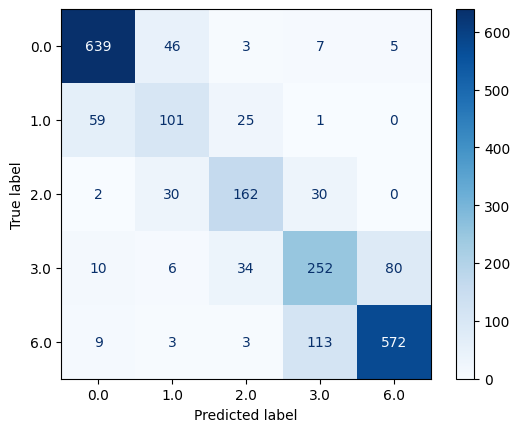

Report of Training:
              precision    recall  f1-score   support

         0.0       0.89      0.91      0.90       700
         1.0       0.54      0.54      0.54       186
         2.0       0.71      0.72      0.72       224
         3.0       0.63      0.66      0.64       382
         6.0       0.87      0.82      0.84       700

    accuracy                           0.79      2192
   macro avg       0.73      0.73      0.73      2192
weighted avg       0.79      0.79      0.79      2192

14/14 [==============================] - 0s 357us/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


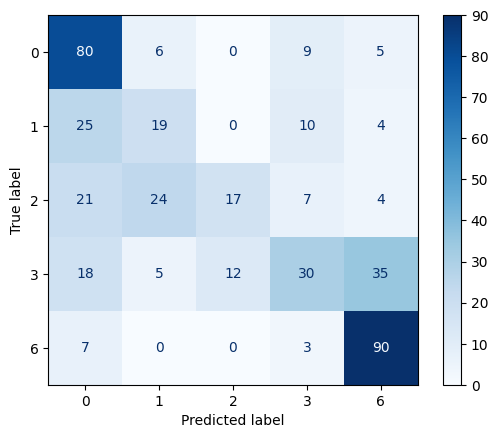

Report of Testing:
              precision    recall  f1-score   support

           0       0.53      0.80      0.64       100
           1       0.35      0.33      0.34        58
           2       0.59      0.23      0.33        73
           3       0.51      0.30      0.38       100
           6       0.65      0.90      0.76       100

    accuracy                           0.55       431
   macro avg       0.53      0.51      0.49       431
weighted avg       0.54      0.55      0.51       431

Train data is D1NAMO and test data is BigLab with threshold 80
69/69 [==============================] - 0s 313us/step


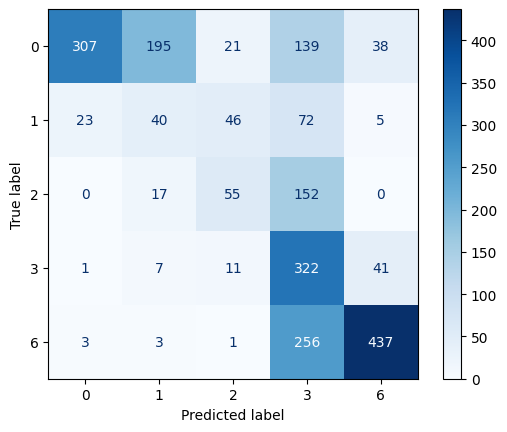

Report of Testing:
              precision    recall  f1-score   support

           0       0.92      0.44      0.59       700
           1       0.15      0.22      0.18       186
           2       0.41      0.25      0.31       224
           3       0.34      0.84      0.49       382
           6       0.84      0.62      0.72       700

    accuracy                           0.53      2192
   macro avg       0.53      0.47      0.46      2192
weighted avg       0.68      0.53      0.55      2192



In [36]:
# Threshold 80 with sampling 700 and 5 classes

# The seed value needs to be called every time so that in every cell and order the model is reproduceable
# Seed value for reproducability according to https://stackoverflow.com/questions/32419510/how-to-get-reproducible-results-in-keras
seed_value=3
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.compat.v1.set_random_seed(seed_value)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

# define the dictionaries to undersample the data for each class, then call the undersampling function
dict_under = {0: 700, 1: 186, 2: 224, 3: 382, 4: 0, 5: 0, 6: 700}
X_under_pre, y_under_pre = undersampling(X_pre, y_pre, dict_under)
dict_under_t1 = {0: 100, 1: 58, 2: 73, 3: 100, 4: 0, 5: 0, 6: 100}
X_under_t1, y_under_t1 = undersampling(X_t1, y_t1, dict_under_t1)

# call the function start_model to initialize the model and visualize the confusion matrices
print("Train data is BigLab and test data is D1NAMO with threshold 80")
start_model(X_under_pre, y_under_pre, X_under_t1, y_under_t1, "1DCNN_Trained_BigLab_80_700", "1DCNN_Tested_D1NAMO_80_700", batchsize=50, epoch= 500)
print("Train data is D1NAMO and test data is BigLab with threshold 80")
# Load trained D1NAMO model and test the BigLab data with 75 threshold
Testing_from_D1NAMO("Models/1DCNN_Trained_D1NAMO_70.hdf5", X_under_pre, y_under_pre, "Confusion_Matrices/1DCNN_Tested_BigLab_80_700.png" )

## Threshold 85

In [37]:
# define the paths and call the load data function to have a time series representation of the data
path_pre = '/Users/beyzacinar/Desktop/HYPO/CODE_Notebook_new/data_thresholds_bereinigt/thresh85'
X_pre, y_pre = load_data(path_pre)
path_t1 = '/Users/beyzacinar/Desktop/TSC_Hypoglycemia/Stacked_Daten/bereinigtStacked/d1namo'
X_t1, y_t1 = load_data(path_t1)

Train data is BigLab and test data is D1NAMO with threshold 85
Epoch 1/500


/var/folders/t1/sgksm9r9385br4pts_lckj1w0000gn/T/ipykernel_1874/3598073534.py:131: RuntimeWarning: divide by zero encountered in scalar divide
  weight_for_4 = (1/class_occurences[4]) * (total/number_classes)
/var/folders/t1/sgksm9r9385br4pts_lckj1w0000gn/T/ipykernel_1874/3598073534.py:132: RuntimeWarning: divide by zero encountered in scalar divide
  weight_for_5= (1/class_occurences[5]) * (total/number_classes)


 1/27 [>.............................] - ETA: 5s - loss: 1.4235 - sparse_categorical_accuracy: 0.2000
Epoch 1: val_loss improved from inf to 5.63563, saving model to CustomModel.weights.hdf5
27/27 [==============================] - 0s 4ms/step - loss: 1.1809 - sparse_categorical_accuracy: 0.3850 - val_loss: 5.6356 - val_sparse_categorical_accuracy: 0.2365 - lr: 0.0010
Epoch 2/500
 1/27 [>.............................] - ETA: 0s - loss: 1.0024 - sparse_categorical_accuracy: 0.4600
Epoch 2: val_loss improved from 5.63563 to 5.56136, saving model to CustomModel.weights.hdf5
27/27 [==============================] - 0s 2ms/step - loss: 0.9028 - sparse_categorical_accuracy: 0.5004 - val_loss: 5.5614 - val_sparse_categorical_accuracy: 0.2335 - lr: 0.0010
Epoch 3/500
 1/27 [>.............................] - ETA: 0s - loss: 0.8986 - sparse_categorical_accuracy: 0.4600
Epoch 3: val_loss improved from 5.56136 to 4.54818, saving model to CustomModel.weights.hdf5
27/27 [============================

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 7: val_loss improved from 2.46926 to 1.99577, saving model to CustomModel.weights.hdf5
27/27 [==============================] - 0s 1ms/step - loss: 0.6296 - sparse_categorical_accuracy: 0.6225 - val_loss: 1.9958 - val_sparse_categorical_accuracy: 0.3593 - lr: 0.0010
Epoch 8/500
 1/27 [>.............................] - ETA: 0s - loss: 0.5649 - sparse_categorical_accuracy: 0.6600
Epoch 8: val_loss improved from 1.99577 to 1.60466, saving model to CustomModel.weights.hdf5
27/27 [==============================] - 0s 1ms/step - loss: 0.5875 - sparse_categorical_accuracy: 0.6554 - val_loss: 1.6047 - val_sparse_categorical_accuracy: 0.4431 - lr: 0.0010
Epoch 9/500
 1/27 [>.............................] - ETA: 0s - loss: 0.7670 - sparse_categorical_accuracy: 0.4600
Epoch 9: val_loss did not improve from 1.60466
27/27 [==============================] - 0s 1ms/step - loss: 0.6012 - sparse_categorical_accuracy: 0.6330 - val_loss: 1.6715 - val_sparse_categorical_accuracy: 0.3982 - lr: 0.001

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 40: val_loss improved from 0.57567 to 0.57533, saving model to CustomModel.weights.hdf5
27/27 [==============================] - 0s 1ms/step - loss: 0.4742 - sparse_categorical_accuracy: 0.7216 - val_loss: 0.5753 - val_sparse_categorical_accuracy: 0.7515 - lr: 4.0000e-05
Epoch 41/500
 1/27 [>.............................] - ETA: 0s - loss: 0.4301 - sparse_categorical_accuracy: 0.7400
Epoch 41: val_loss improved from 0.57533 to 0.56592, saving model to CustomModel.weights.hdf5
27/27 [==============================] - 0s 1ms/step - loss: 0.4868 - sparse_categorical_accuracy: 0.7141 - val_loss: 0.5659 - val_sparse_categorical_accuracy: 0.7575 - lr: 4.0000e-05
Epoch 42/500
 1/27 [>.............................] - ETA: 0s - loss: 0.4991 - sparse_categorical_accuracy: 0.7600
Epoch 42: val_loss improved from 0.56592 to 0.56432, saving model to CustomModel.weights.hdf5
27/27 [==============================] - 0s 1ms/step - loss: 0.4563 - sparse_categorical_accuracy: 0.7365 - val_loss: 0

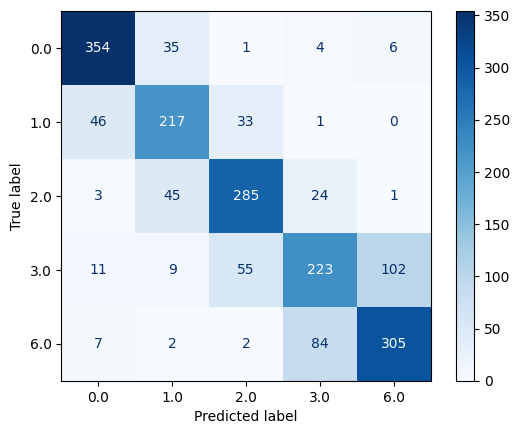

Report of Training:
              precision    recall  f1-score   support

         0.0       0.84      0.89      0.86       400
         1.0       0.70      0.73      0.72       297
         2.0       0.76      0.80      0.78       358
         3.0       0.66      0.56      0.61       400
         6.0       0.74      0.76      0.75       400

    accuracy                           0.75      1855
   macro avg       0.74      0.75      0.74      1855
weighted avg       0.74      0.75      0.74      1855

14/14 [==============================] - 0s 398us/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Report of Testing:
              precision    recall  f1-score   support

           0       0.59      0.64      0.62       100
           1       0.24      0.45      0.31        58
           2       0.29      0.34      0.31        73
           3       0.43      0.28      0.34       100
           6       0.81      0.51      0.63       100

    accuracy                           0.45       431
   macro avg       0.47      0.44      0.44       431
weighted avg       0.51      0.45      0.46       431

Train data is D1NAMO and test data is BigLab with threshold 85
58/58 [==============================] - 0s 429us/step


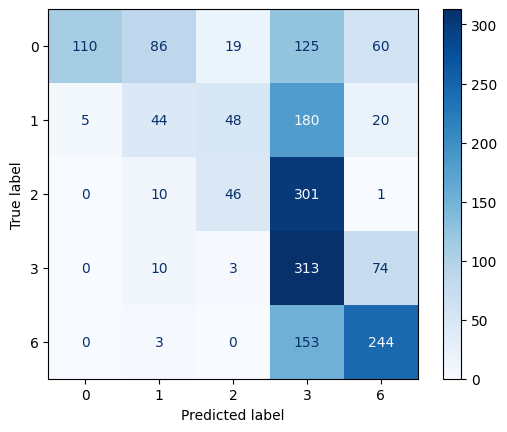

Report of Testing:
              precision    recall  f1-score   support

           0       0.96      0.28      0.43       400
           1       0.29      0.15      0.20       297
           2       0.40      0.13      0.19       358
           3       0.29      0.78      0.43       400
           6       0.61      0.61      0.61       400

    accuracy                           0.41      1855
   macro avg       0.51      0.39      0.37      1855
weighted avg       0.52      0.41      0.38      1855



In [38]:
# Threshold 85 with 400 sampling and 5 classes

# The seed value needs to be called every time so that in every cell and order the model is reproduceable
# Seed value for reproducability according to https://stackoverflow.com/questions/32419510/how-to-get-reproducible-results-in-keras
seed_value=3
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.compat.v1.set_random_seed(seed_value)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

# define the dictionaries to undersample the data for each class, then call the undersampling function
dict_under = {0: 400, 1: 297, 2: 358, 3: 400,  4: 0, 5: 0, 6: 400}
X_under_pre, y_under_pre = undersampling(X_pre, y_pre, dict_under)
dict_under_t1 = {0: 100, 1: 58, 2: 73, 3: 100, 4: 0, 5: 0, 6: 100}
X_under_t1, y_under_t1 = undersampling(X_t1, y_t1, dict_under_t1)

# call the function start_model to initialize the model and visualize the confusion matrices
print("Train data is BigLab and test data is D1NAMO with threshold 85")
start_model(X_under_pre, y_under_pre, X_under_t1, y_under_t1, "1DCNN_Trained_BigLab_85_400", "1DCNN_Tested_D1NAMO_85_400", batchsize=50, epoch= 500)
print("Train data is D1NAMO and test data is BigLab with threshold 85")
# Load trained D1NAMO model and test the BigLab data with 85 threshold
Testing_from_D1NAMO("Models/1DCNN_Trained_D1NAMO_70.hdf5", X_under_pre, y_under_pre, "Confusion_Matrices/1DCNN_Tested_BigLab_85_400.png")

Train data is BigLab and test data is D1NAMO with threshold 85
Epoch 1/500


/var/folders/t1/sgksm9r9385br4pts_lckj1w0000gn/T/ipykernel_1874/3598073534.py:131: RuntimeWarning: divide by zero encountered in scalar divide
  weight_for_4 = (1/class_occurences[4]) * (total/number_classes)
/var/folders/t1/sgksm9r9385br4pts_lckj1w0000gn/T/ipykernel_1874/3598073534.py:132: RuntimeWarning: divide by zero encountered in scalar divide
  weight_for_5= (1/class_occurences[5]) * (total/number_classes)


 1/38 [..............................] - ETA: 7s - loss: 1.5933 - sparse_categorical_accuracy: 0.1400
Epoch 1: val_loss improved from inf to 5.09124, saving model to CustomModel.weights.hdf5
38/38 [==============================] - 0s 3ms/step - loss: 1.1276 - sparse_categorical_accuracy: 0.4345 - val_loss: 5.0912 - val_sparse_categorical_accuracy: 0.2839 - lr: 0.0010
Epoch 2/500
 1/38 [..............................] - ETA: 0s - loss: 0.8925 - sparse_categorical_accuracy: 0.4600
Epoch 2: val_loss improved from 5.09124 to 4.36415, saving model to CustomModel.weights.hdf5
38/38 [==============================] - 0s 1ms/step - loss: 0.8377 - sparse_categorical_accuracy: 0.5395 - val_loss: 4.3642 - val_sparse_categorical_accuracy: 0.2987 - lr: 0.0010
Epoch 3/500
 1/38 [..............................] - ETA: 0s - loss: 0.7611 - sparse_categorical_accuracy: 0.6200
Epoch 3: val_loss improved from 4.36415 to 3.47925, saving model to CustomModel.weights.hdf5
38/38 [============================

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 6: val_loss did not improve from 1.53077
38/38 [==============================] - 0s 1ms/step - loss: 0.6192 - sparse_categorical_accuracy: 0.6430 - val_loss: 1.6822 - val_sparse_categorical_accuracy: 0.4195 - lr: 0.0010
Epoch 7/500
 1/38 [..............................] - ETA: 0s - loss: 0.6819 - sparse_categorical_accuracy: 0.5400
Epoch 7: val_loss improved from 1.53077 to 1.33944, saving model to CustomModel.weights.hdf5
38/38 [==============================] - 0s 1ms/step - loss: 0.5906 - sparse_categorical_accuracy: 0.6562 - val_loss: 1.3394 - val_sparse_categorical_accuracy: 0.5148 - lr: 0.0010
Epoch 8/500
 1/38 [..............................] - ETA: 0s - loss: 0.4973 - sparse_categorical_accuracy: 0.7200
Epoch 8: val_loss improved from 1.33944 to 1.11524, saving model to CustomModel.weights.hdf5
38/38 [==============================] - 0s 1ms/step - loss: 0.6041 - sparse_categorical_accuracy: 0.6493 - val_loss: 1.1152 - val_sparse_categorical_accuracy: 0.5000 - lr: 0.001

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 27: val_loss improved from 0.55470 to 0.55214, saving model to CustomModel.weights.hdf5
38/38 [==============================] - 0s 1ms/step - loss: 0.4844 - sparse_categorical_accuracy: 0.7215 - val_loss: 0.5521 - val_sparse_categorical_accuracy: 0.7542 - lr: 4.0000e-05
Epoch 28/500
 1/38 [..............................] - ETA: 0s - loss: 0.4453 - sparse_categorical_accuracy: 0.7400
Epoch 28: val_loss did not improve from 0.55214
38/38 [==============================] - 0s 971us/step - loss: 0.4921 - sparse_categorical_accuracy: 0.7109 - val_loss: 0.5527 - val_sparse_categorical_accuracy: 0.7585 - lr: 4.0000e-05
Epoch 29/500
 1/38 [..............................] - ETA: 0s - loss: 0.5165 - sparse_categorical_accuracy: 0.7200
Epoch 29: val_loss improved from 0.55214 to 0.54795, saving model to CustomModel.weights.hdf5
38/38 [==============================] - 0s 1ms/step - loss: 0.4976 - sparse_categorical_accuracy: 0.7088 - val_loss: 0.5480 - val_sparse_categorical_accuracy: 0.7

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 33: val_loss did not improve from 0.50958
38/38 [==============================] - 0s 995us/step - loss: 0.4729 - sparse_categorical_accuracy: 0.7390 - val_loss: 0.5249 - val_sparse_categorical_accuracy: 0.7669 - lr: 4.0000e-05
Epoch 34/500
 1/38 [..............................] - ETA: 0s - loss: 0.7788 - sparse_categorical_accuracy: 0.6000
Epoch 34: val_loss improved from 0.50958 to 0.50153, saving model to CustomModel.weights.hdf5
38/38 [==============================] - 0s 1ms/step - loss: 0.4654 - sparse_categorical_accuracy: 0.7432 - val_loss: 0.5015 - val_sparse_categorical_accuracy: 0.7818 - lr: 4.0000e-05
Epoch 35/500
 1/38 [..............................] - ETA: 0s - loss: 0.6026 - sparse_categorical_accuracy: 0.6800
Epoch 35: val_loss improved from 0.50153 to 0.49079, saving model to CustomModel.weights.hdf5
38/38 [==============================] - 0s 1ms/step - loss: 0.4658 - sparse_categorical_accuracy: 0.7501 - val_loss: 0.4908 - val_sparse_categorical_accuracy: 0.7

Report of Training:
              precision    recall  f1-score   support

         0.0       0.88      0.91      0.89       700
         1.0       0.64      0.71      0.67       297
         2.0       0.75      0.76      0.75       358
         3.0       0.65      0.55      0.59       564
         6.0       0.76      0.78      0.77       700

    accuracy                           0.75      2619
   macro avg       0.73      0.74      0.74      2619
weighted avg       0.75      0.75      0.75      2619

14/14 [==============================] - 0s 718us/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Report of Testing:
              precision    recall  f1-score   support

           0       0.50      0.51      0.50       100
           1       0.15      0.48      0.23        58
           2       0.32      0.16      0.22        73
           3       0.50      0.21      0.30       100
           6       0.82      0.51      0.63       100

    accuracy                           0.38       431
   macro avg       0.46      0.38      0.37       431
weighted avg       0.50      0.38      0.40       431

Train data is D1NAMO and test data is BigLab with threshold 85
82/82 [==============================] - 0s 303us/step


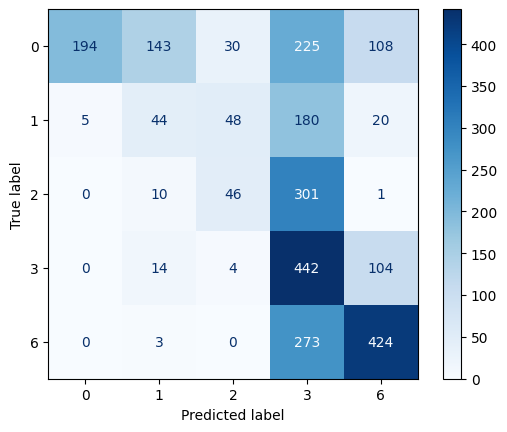

Report of Testing:
              precision    recall  f1-score   support

           0       0.97      0.28      0.43       700
           1       0.21      0.15      0.17       297
           2       0.36      0.13      0.19       358
           3       0.31      0.78      0.45       564
           6       0.65      0.61      0.62       700

    accuracy                           0.44      2619
   macro avg       0.50      0.39      0.37      2619
weighted avg       0.57      0.44      0.42      2619



In [39]:
# Threshold 85 with 700 sampling and 5 classes

# The seed value needs to be called every time so that in every cell and order the model is reproduceable
# Seed value for reproducability according to https://stackoverflow.com/questions/32419510/how-to-get-reproducible-results-in-keras
seed_value=3
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.compat.v1.set_random_seed(seed_value)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

# define the dictionaries to undersample the data for each class, then call the undersampling function
dict_under = {0: 700, 1: 297, 2: 358, 3: 564,  4: 0, 5: 0, 6: 700}
X_under_pre, y_under_pre = undersampling(X_pre, y_pre, dict_under)
dict_under_t1 = {0: 100, 1: 58, 2: 73, 3: 100, 4: 0, 5: 0, 6: 100}
X_under_t1, y_under_t1 = undersampling(X_t1, y_t1, dict_under_t1)

# call the function start_model to initialize the model and visualize the confusion matrices
print("Train data is BigLab and test data is D1NAMO with threshold 85")
start_model(X_under_pre, y_under_pre, X_under_t1, y_under_t1, "1DCNN_Trained_BigLab_85_700", "1DCNN_Tested_D1NAMO_85_700", batchsize=50, epoch= 500)
print("Train data is D1NAMO and test data is BigLab with threshold 85")
# Load trained D1NAMO model and test the BigLab data with 85 threshold
Testing_from_D1NAMO("Models/1DCNN_Trained_D1NAMO_70.hdf5", X_under_pre, y_under_pre, "Confusion_Matrices/1DCNN_Tested_BigLab_85_700.png")

In [40]:
# Threshold 85 with 1000 sampling and 5 classes

# The seed value needs to be called every time so that in every cell and order the model is reproduceable
# Seed value for reproducability according to https://stackoverflow.com/questions/32419510/how-to-get-reproducible-results-in-keras
seed_value=3
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)
tf.compat.v1.set_random_seed(seed_value)
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

# define the dictionaries to undersample the data for each class, then call the undersampling function
dict_under = {0: 1000, 1: 297, 2: 358, 3: 564, 4: 0, 5: 0, 6: 1000}
X_under_pre, y_under_pre = undersampling(X_pre, y_pre, dict_under)
dict_under_t1 = {0: 100, 1: 58, 2: 73, 3: 100, 4: 0, 5: 0, 6: 100}
X_under_t1, y_under_t1 = undersampling(X_t1, y_t1, dict_under_t1)

# call the function start_model to initialize the model and visualize the confusion matrices
print("Train data is BigLab and test data is D1NAMO with threshold 85")
start_model(X_under_pre, y_under_pre, X_under_t1, y_under_t1, "1DCNN_Trained_BigLab_85_1000", "1DCNN_Tested_D1NAMO_85_1000", batchsize=50, epoch= 500)
print("Train data is D1NAMO and test data is BigLab with threshold 85")
# Load trained D1NAMO model and test the BigLab data with 85 threshold
Testing_from_D1NAMO("Models/1DCNN_Trained_D1NAMO_70.hdf5", X_under_pre, y_under_pre, "Confusion_Matrices/1DCNN_Tested_BigLab_85_1000.png")

Train data is BigLab and test data is D1NAMO with threshold 85
Epoch 1/500


/var/folders/t1/sgksm9r9385br4pts_lckj1w0000gn/T/ipykernel_1874/3598073534.py:131: RuntimeWarning: divide by zero encountered in scalar divide
  weight_for_4 = (1/class_occurences[4]) * (total/number_classes)
/var/folders/t1/sgksm9r9385br4pts_lckj1w0000gn/T/ipykernel_1874/3598073534.py:132: RuntimeWarning: divide by zero encountered in scalar divide
  weight_for_5= (1/class_occurences[5]) * (total/number_classes)


 1/47 [..............................] - ETA: 9s - loss: 1.5683 - sparse_categorical_accuracy: 0.0800
Epoch 1: val_loss improved from inf to 4.71984, saving model to CustomModel.weights.hdf5
47/47 [==============================] - 0s 3ms/step - loss: 1.1046 - sparse_categorical_accuracy: 0.4588 - val_loss: 4.7198 - val_sparse_categorical_accuracy: 0.3121 - lr: 0.0010
Epoch 2/500
 1/47 [..............................] - ETA: 0s - loss: 0.7454 - sparse_categorical_accuracy: 0.5800
Epoch 2: val_loss improved from 4.71984 to 3.94040, saving model to CustomModel.weights.hdf5
47/47 [==============================] - 0s 1ms/step - loss: 0.8017 - sparse_categorical_accuracy: 0.5710 - val_loss: 3.9404 - val_sparse_categorical_accuracy: 0.3207 - lr: 0.0010
Epoch 3/500
 1/47 [..............................] - ETA: 0s - loss: 0.6575 - sparse_categorical_accuracy: 0.6200
Epoch 3: val_loss improved from 3.94040 to 2.95905, saving model to CustomModel.weights.hdf5
47/47 [============================

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 5: val_loss improved from 2.40044 to 1.44323, saving model to CustomModel.weights.hdf5
47/47 [==============================] - 0s 1ms/step - loss: 0.6263 - sparse_categorical_accuracy: 0.6586 - val_loss: 1.4432 - val_sparse_categorical_accuracy: 0.4655 - lr: 0.0010
Epoch 6/500
 1/47 [..............................] - ETA: 0s - loss: 0.4616 - sparse_categorical_accuracy: 0.7000
Epoch 6: val_loss improved from 1.44323 to 0.75243, saving model to CustomModel.weights.hdf5
47/47 [==============================] - 0s 1ms/step - loss: 0.6067 - sparse_categorical_accuracy: 0.6841 - val_loss: 0.7524 - val_sparse_categorical_accuracy: 0.7155 - lr: 0.0010
Epoch 7/500
 1/47 [..............................] - ETA: 0s - loss: 0.6130 - sparse_categorical_accuracy: 0.6000
Epoch 7: val_loss did not improve from 0.75243
47/47 [==============================] - 0s 923us/step - loss: 0.6107 - sparse_categorical_accuracy: 0.6577 - val_loss: 0.8735 - val_sparse_categorical_accuracy: 0.6569 - lr: 0.0

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 28/500
 1/47 [..............................] - ETA: 0s - loss: 0.4274 - sparse_categorical_accuracy: 0.7400
Epoch 28: val_loss did not improve from 0.55634
47/47 [==============================] - 0s 932us/step - loss: 0.4861 - sparse_categorical_accuracy: 0.7281 - val_loss: 0.5568 - val_sparse_categorical_accuracy: 0.7483 - lr: 2.0000e-04
Epoch 29/500
 1/47 [..............................] - ETA: 0s - loss: 0.4648 - sparse_categorical_accuracy: 0.7600
Epoch 29: val_loss improved from 0.55634 to 0.55345, saving model to CustomModel.weights.hdf5
47/47 [==============================] - 0s 1ms/step - loss: 0.5117 - sparse_categorical_accuracy: 0.7246 - val_loss: 0.5535 - val_sparse_categorical_accuracy: 0.7621 - lr: 2.0000e-04
Epoch 30/500
 1/47 [..............................] - ETA: 0s - loss: 0.4327 - sparse_categorical_accuracy: 0.8200
Epoch 30: val_loss did not improve from 0.55345
47/47 [==============================] - 0s 923us/step - loss: 0.5066 - sparse_categorical_accu

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 24: val_loss did not improve from 0.53846
47/47 [==============================] - 0s 983us/step - loss: 0.5072 - sparse_categorical_accuracy: 0.7290 - val_loss: 0.5714 - val_sparse_categorical_accuracy: 0.7672 - lr: 4.0000e-05
Epoch 25/500
 1/47 [..............................] - ETA: 0s - loss: 0.3939 - sparse_categorical_accuracy: 0.7000
Epoch 25: val_loss did not improve from 0.53846

Epoch 25: ReduceLROnPlateau reducing learning rate to 8.000000525498762e-06.
47/47 [==============================] - 0s 948us/step - loss: 0.5028 - sparse_categorical_accuracy: 0.7333 - val_loss: 0.5428 - val_sparse_categorical_accuracy: 0.7828 - lr: 4.0000e-05
Epoch 26/500
 1/47 [..............................] - ETA: 0s - loss: 0.2730 - sparse_categorical_accuracy: 0.8400
Epoch 26: val_loss improved from 0.53846 to 0.53371, saving model to CustomModel.weights.hdf5
47/47 [==============================] - 0s 1ms/step - loss: 0.4871 - sparse_categorical_accuracy: 0.7441 - val_loss: 0.5337 - va

Report of Training:
              precision    recall  f1-score   support

         0.0       0.91      0.91      0.91      1000
         1.0       0.58      0.71      0.64       297
         2.0       0.74      0.73      0.74       358
         3.0       0.59      0.59      0.59       564
         6.0       0.83      0.79      0.81      1000

    accuracy                           0.78      3219
   macro avg       0.73      0.74      0.74      3219
weighted avg       0.78      0.78      0.78      3219

14/14 [==============================] - 0s 417us/step


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Report of Testing:
              precision    recall  f1-score   support

           0       0.54      0.54      0.54       100
           1       0.25      0.34      0.29        58
           2       0.40      0.36      0.38        73
           3       0.33      0.42      0.37       100
           6       0.73      0.43      0.54       100

    accuracy                           0.43       431
   macro avg       0.45      0.42      0.42       431
weighted avg       0.47      0.43      0.44       431

Train data is D1NAMO and test data is BigLab with threshold 85
101/101 [==============================] - 0s 284us/step


Report of Testing:
              precision    recall  f1-score   support

           0       0.98      0.29      0.45      1000
           1       0.16      0.15      0.16       297
           2       0.32      0.13      0.18       358
           3       0.27      0.78      0.40       564
           6       0.69      0.61      0.65      1000

    accuracy                           0.44      3219
   macro avg       0.49      0.39      0.37      3219
weighted avg       0.62      0.44      0.44      3219

